In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


pd.set_option('display.max_colwidth', None)  # Show full content in each cell
pd.set_option('display.max_rows', None)      # Show all rows
pd.set_option('display.max_columns', None)   # Show all columns

In [2]:
clash_df = pd.read_csv('./feature_table_by_catg/armed_clash_df.csv')
airstrike_df = pd.read_csv('./feature_table_by_catg/air_df.csv')
shelling_df = pd.read_csv('./feature_table_by_catg/attack_df.csv')
disrupt_df = pd.read_csv('./feature_table_by_catg/disrupt_df.csv')
regain_df = pd.read_csv('./feature_table_by_catg/regain_df.csv')

/var/folders/m1/y50gr9tn5796vpljdx0my4sc0000gn/T/ipykernel_28989/3713966127.py:1: DtypeWarning: Columns (30) have mixed types. Specify dtype option on import or set low_memory=False.
  clash_df = pd.read_csv('./feature_table_by_catg/armed_clash_df.csv')


In [3]:
clash_cols = set(clash_df.columns)
shelling_cols = set(shelling_df.columns)
disrupt_cols = set(disrupt_df.columns)
airstrike_cols = set(airstrike_df.columns)
regain_cols = set(regain_df.columns)

mutual_cols = clash_cols.intersection(shelling_cols).intersection(disrupt_cols).intersection(airstrike_cols).intersection(regain_cols)
print(len(mutual_cols))
print(mutual_cols)

# new columns amt
print(len(clash_cols-mutual_cols))
print(len(shelling_cols-mutual_cols))
print(len(disrupt_cols-mutual_cols))
print(len(airstrike_cols-mutual_cols))
print(len(regain_cols-mutual_cols))

34
{'latitude', 'interaction', 'admin3', 'event_type', 'inter1', 'assoc_actor_2', 'source_scale', 'admin1', 'tags', 'actor2_ntnlty', 'notes', 'source', 'sub_event_type', 'Unnamed: 0', 'year', 'assoc_actor_1', 'actor1_ntnlty', 'fatalities', 'time_precision', 'country', 'timestamp', 'iso', 'event_date', 'actor1', 'location', 'disorder_type', 'actor2', 'event_id_cnty', 'geo_precision', 'civilian_targeting', 'inter2', 'longitude', 'admin2', 'region'}
14
23
45
8
0


Columns to keep
- count_row_subevent
- count_location_subevent
- mean_lat_subevent
- mean_long_subevent
- sum_fatalities_subevent
- count_actor1_rus_subevent
- count_actor1_ukr_subevent
- count_actor2_rus_subevent
- count_actor2_ukr_subevent
- flag (or)
- n (sum)
- supported (or)
- losses (sum)
- is (or)
- boolean col, else (or)

## Vectorization

In [4]:
def common_col_process(df,subevent):
    grouped_df = df.groupby('event_date').agg(
        **{
            f"count_row_{subevent}": ('sub_event_type', 'count'),
            f"count_location_{subevent}": ('location', 'nunique'),
            f"mean_lat_{subevent}": ('latitude', 'mean'),
            f"mean_long_{subevent}": ('longitude', 'mean'),
            f"sum_fatalities_{subevent}": ('fatalities', 'sum'),
            f"count_actor1_rus_{subevent}": ('actor1', lambda x: (x.str.contains('RUSSIA', case=False, na=False)).sum()),
            f"count_actor1_ukr_{subevent}": ('actor1', lambda x: (x.str.contains('UKRAINE', case=False, na=False)).sum()),
            f"count_actor2_rus_{subevent}": ('actor2', lambda x: (x.str.contains('RUSSIA', case=False, na=False)).sum()),
            f"count_actor2_ukr_{subevent}": ('actor2', lambda x: (x.str.contains('UKRAINE', case=False, na=False)).sum()),
        }
    ).reset_index()
    return grouped_df

def determine_agg(column_name):
    if "flag" in column_name or "supported" in column_name or "is" in column_name:
        return "any"
    elif "losses" in column_name or "n_" in column_name or "_n" in column_name:
        return "sum"
    else:
        return "any"

### Clash

In [5]:
clash_common_df = common_col_process(clash_df, 'clash')
clash_common_df.head(10)

,event_date,count_row_clash,count_location_clash,mean_lat_clash,mean_long_clash,sum_fatalities_clash,count_actor1_rus_clash,count_actor1_ukr_clash,count_actor2_rus_clash,count_actor2_ukr_clash
0,2018-01-01,6,6,47.933950,38.178617,0,0,2,0,4
1,2018-01-02,9,9,47.700089,37.763967,0,0,6,0,3
2,2018-01-03,10,10,47.735560,38.816250,1,1,5,1,5
3,2018-01-04,5,5,47.177400,39.504840,1,1,3,1,1
4,2018-01-05,9,9,48.247989,37.938789,1,0,7,0,2
5,2018-01-06,11,11,48.181982,38.057836,0,0,7,0,4
6,2018-01-07,12,12,47.729967,37.845158,0,0,5,0,7
7,2018-01-08,15,15,47.849840,37.825233,0,0,11,0,4
8,2018-01-09,13,13,47.998892,37.912338,0,0,10,0,3
9,2018-01-10,8,8,48.083137,37.861263,1,0,6,0,2


In [6]:
clash_agg_dict = {col: determine_agg(col) for col in clash_df.columns if col in (clash_cols-mutual_cols)}
clash_agg_dict

{'is_supported': 'any',
 'is_shelling': 'any',
 'vehicle_losses': 'sum',
 'armored_vehicle_losses': 'sum',
 'car_losses': 'sum',
 'boat_losses': 'sum',
 'drone_losses': 'sum',
 'cannon_losses': 'sum',
 'uav_losses': 'sum',
 'mortar_losses': 'sum',
 'air_forces_supported': 'any',
 'artillery_supported': 'any',
 'aviation_supported': 'any',
 'air_units_supported': 'any'}

In [7]:
clash_agg_df = clash_df.groupby('event_date').agg(clash_agg_dict).reset_index()
clash_agg_df.tail(10)

,event_date,is_supported,is_shelling,vehicle_losses,armored_vehicle_losses,car_losses,boat_losses,drone_losses,cannon_losses,uav_losses,mortar_losses,air_forces_supported,artillery_supported,aviation_supported,air_units_supported
2432,2024-09-18,True,True,0,8,2,0,86,0,0,0,False,True,False,True
2433,2024-09-19,True,True,0,0,62,0,161,0,0,24,True,False,False,False
2434,2024-09-20,True,True,206,68,0,3,91,0,52,1,True,True,True,False
2435,2024-09-21,True,False,4,10,8,0,0,0,0,0,False,True,True,False
2436,2024-09-22,True,False,3,4,4,0,0,0,0,0,False,True,True,False
2437,2024-09-23,True,True,0,1,6,0,162,0,0,0,False,True,True,True
2438,2024-09-24,True,False,0,8,6,0,0,0,0,0,False,True,True,False
2439,2024-09-25,True,False,0,38,275,2,1,0,0,0,True,True,True,False
2440,2024-09-26,True,True,67,10,5,3,136,22,36,2,True,True,True,False
2441,2024-09-27,True,True,0,30,10,0,91,0,0,0,False,True,True,False


In [8]:
clash_vectorized_df = pd.merge(clash_common_df, clash_agg_df, on='event_date', how='outer')
clash_vectorized_df = clash_vectorized_df.rename(columns=lambda col: f"{col}_clash" if col[-5:] != 'clash' and col != 'event_date' else col)

# final result
clash_vectorized_df.tail(10)

,event_date,count_row_clash,count_location_clash,mean_lat_clash,mean_long_clash,sum_fatalities_clash,count_actor1_rus_clash,count_actor1_ukr_clash,count_actor2_rus_clash,count_actor2_ukr_clash,is_supported_clash,is_shelling_clash,vehicle_losses_clash,armored_vehicle_losses_clash,car_losses_clash,boat_losses_clash,drone_losses_clash,cannon_losses_clash,uav_losses_clash,mortar_losses_clash,air_forces_supported_clash,artillery_supported_clash,aviation_supported_clash,air_units_supported_clash
2432,2024-09-18,73,73,49.035703,37.156979,278,72,1,2,71,True,True,0,8,2,0,86,0,0,0,False,True,False,True
2433,2024-09-19,50,50,48.984290,36.700218,162,44,6,6,44,True,True,0,0,62,0,161,0,0,24,True,False,False,False
2434,2024-09-20,87,87,48.789886,37.193843,261,81,6,6,81,True,True,206,68,0,3,91,0,52,1,True,True,True,False
2435,2024-09-21,69,69,48.965626,37.195336,281,64,5,5,64,True,False,4,10,8,0,0,0,0,0,False,True,True,False
2436,2024-09-22,62,62,49.070806,37.221074,210,53,9,9,53,True,False,3,4,4,0,0,0,0,0,False,True,True,False
2437,2024-09-23,72,72,48.815861,37.174192,366,70,2,2,70,True,True,0,1,6,0,162,0,0,0,False,True,True,True
2438,2024-09-24,58,58,49.097107,37.249343,42,55,3,3,55,True,False,0,8,6,0,0,0,0,0,False,True,True,False
2439,2024-09-25,43,43,48.960426,36.880870,227,41,2,2,41,True,False,0,38,275,2,1,0,0,0,True,True,True,False
2440,2024-09-26,58,55,48.899645,37.021650,267,54,4,4,54,True,True,67,10,5,3,136,22,36,2,True,True,True,False
2441,2024-09-27,73,73,48.859486,37.029173,92,72,1,1,72,True,True,0,30,10,0,91,0,0,0,False,True,True,False


### Shelling

In [9]:
shelling_common_df = common_col_process(shelling_df, 'shelling')
shelling_common_df.head(10)

,event_date,count_row_shelling,count_location_shelling,mean_lat_shelling,mean_long_shelling,sum_fatalities_shelling,count_actor1_rus_shelling,count_actor1_ukr_shelling,count_actor2_rus_shelling,count_actor2_ukr_shelling
0,2018-01-01,11,11,47.986200,37.967682,0,0,10,0,1
1,2018-01-02,5,5,48.403960,38.404260,0,0,2,0,1
2,2018-01-03,13,13,48.072392,37.906169,0,0,6,0,3
3,2018-01-04,8,8,48.169313,38.138075,0,0,5,0,1
4,2018-01-05,11,11,47.941482,38.006118,0,0,8,0,1
5,2018-01-06,8,8,48.013762,37.979575,0,0,5,0,1
6,2018-01-07,7,7,48.115314,37.969257,0,0,7,0,0
7,2018-01-08,15,15,48.112653,38.122987,0,0,8,0,4
8,2018-01-09,15,15,48.228987,38.138293,0,0,11,0,2
9,2018-01-10,33,33,48.207030,38.040542,3,0,21,0,6


In [10]:
shelling_agg_dict = {col: determine_agg(col) for col in shelling_df.columns if col in (shelling_cols-mutual_cols)}
shelling_agg_dict

{'shelling_flag': 'any',
 'artillery_flag': 'any',
 'missile_flag': 'any',
 'mortar_flag': 'any',
 'missile_type': 'any',
 'anti-tank': 'any',
 'anti-aircraft': 'any',
 'anti-ship': 'any',
 'anti-air': 'any',
 'anti-radar': 'any',
 'grad': 'any',
 'himars': 'any',
 's-300': 'any',
 'uragan': 'any',
 'iskander': 'any',
 'c-300': 'any',
 'mlrs': 'any',
 'ballistic': 'any',
 'tochka': 'any',
 'smerch': 'any',
 'kalibr': 'any',
 'high-precision': 'any',
 'storm-shadow': 'any'}

In [11]:
shelling_agg_df = shelling_df.groupby('event_date').agg(shelling_agg_dict).reset_index()
shelling_agg_df.tail(10)

,event_date,shelling_flag,artillery_flag,missile_flag,mortar_flag,missile_type,anti-tank,anti-aircraft,anti-ship,anti-air,anti-radar,grad,himars,s-300,uragan,iskander,c-300,mlrs,ballistic,tochka,smerch,kalibr,high-precision,storm-shadow
2436,2024-09-18,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2437,2024-09-19,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2438,2024-09-20,False,True,True,True,True,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False
2439,2024-09-21,True,True,True,True,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False
2440,2024-09-22,False,True,True,True,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False
2441,2024-09-23,True,True,True,True,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
2442,2024-09-24,False,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2443,2024-09-25,True,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2444,2024-09-26,True,True,True,True,True,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False
2445,2024-09-27,False,True,True,True,True,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False


In [12]:
shelling_vectorized_df = pd.merge(shelling_common_df, shelling_agg_df, on='event_date', how='outer')
shelling_vectorized_df = shelling_vectorized_df.rename(columns=lambda col: f"{col}_shelling" if col[-8:] != 'shelling' and col != 'event_date' else col)

# final result
shelling_vectorized_df.tail(10)

,event_date,count_row_shelling,count_location_shelling,mean_lat_shelling,mean_long_shelling,sum_fatalities_shelling,count_actor1_rus_shelling,count_actor1_ukr_shelling,count_actor2_rus_shelling,count_actor2_ukr_shelling,shelling_flag_shelling,artillery_flag_shelling,missile_flag_shelling,mortar_flag_shelling,missile_type_shelling,anti-tank_shelling,anti-aircraft_shelling,anti-ship_shelling,anti-air_shelling,anti-radar_shelling,grad_shelling,himars_shelling,s-300_shelling,uragan_shelling,iskander_shelling,c-300_shelling,mlrs_shelling,ballistic_shelling,tochka_shelling,smerch_shelling,kalibr_shelling,high-precision_shelling,storm-shadow_shelling
2436,2024-09-18,22,21,50.948941,34.640745,1,19,3,3,2,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2437,2024-09-19,43,42,49.408230,34.678772,3,37,6,3,3,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2438,2024-09-20,36,36,49.840367,35.118222,8,24,12,1,12,False,True,True,True,True,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False
2439,2024-09-21,66,63,49.041462,34.924583,28,61,5,2,20,True,True,True,True,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False
2440,2024-09-22,49,49,49.544616,35.312124,39,44,5,2,19,False,True,True,True,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False
2441,2024-09-23,40,39,50.086775,34.752562,16,36,4,3,10,True,True,True,True,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
2442,2024-09-24,63,60,48.917389,35.444673,41,56,7,5,22,False,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2443,2024-09-25,57,56,48.704688,34.608933,42,48,9,2,16,True,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2444,2024-09-26,32,30,50.065603,35.379391,4,24,8,5,6,True,True,True,True,True,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False
2445,2024-09-27,21,20,49.959548,35.277176,3,15,6,3,2,False,True,True,True,True,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False


### Disrupt

In [13]:
disrupt_common_df = common_col_process(disrupt_df, 'disrupt')
disrupt_common_df.head(10)

,event_date,count_row_disrupt,count_location_disrupt,mean_lat_disrupt,mean_long_disrupt,sum_fatalities_disrupt,count_actor1_rus_disrupt,count_actor1_ukr_disrupt,count_actor2_rus_disrupt,count_actor2_ukr_disrupt
0,2018-01-09,1,1,49.4103,38.15040,0,0,1,0,1
1,2018-01-10,1,1,48.0150,37.80140,0,0,1,0,1
2,2018-01-14,2,2,48.1975,38.07425,0,0,1,0,1
3,2018-01-18,1,1,48.0150,37.80140,0,0,1,0,1
4,2018-01-21,1,1,48.6197,38.49190,0,0,0,0,1
5,2018-02-02,1,1,59.9310,30.30490,0,1,0,1,0
6,2018-02-07,1,1,48.0150,37.80140,0,0,1,0,0
7,2018-02-10,2,2,52.4909,33.04075,0,1,1,1,1
8,2018-02-14,1,1,48.0150,37.80140,0,0,0,0,1
9,2018-02-15,1,1,48.0150,37.80140,0,0,0,0,1


In [14]:
# drop drone_model column
disrupt_df = disrupt_df.drop(columns=['drone_model'])

In [15]:
disrupt_agg_dict = {col: determine_agg(col) for col in disrupt_df.columns if col in (disrupt_cols-mutual_cols)}
disrupt_agg_dict

{'n_drone_launched': 'sum',
 'flag_drone_launched': 'any',
 'n_drone_intercepted': 'sum',
 'flag_drone_intercepted': 'any',
 'n_kamikaze-drone_launched': 'sum',
 'flag_kamikaze-drone_launched': 'any',
 'n_kamikaze-drone_intercepted': 'sum',
 'flag_kamikaze-drone_intercepted': 'any',
 'n_air-bomb_launched': 'sum',
 'flag_air-bomb_launched': 'any',
 'n_air-bomb_intercepted': 'sum',
 'flag_air-bomb_intercepted': 'any',
 'n_missile_launched': 'any',
 'flag_missile_launched': 'any',
 'n_missile_intercepted': 'any',
 'flag_missile_intercepted': 'any',
 'n_uxo_launched': 'sum',
 'flag_uxo_launched': 'any',
 'n_uxo_intercepted': 'sum',
 'flag_uxo_intercepted': 'any',
 'n_artillery-shell_launched': 'sum',
 'flag_artillery-shell_launched': 'any',
 'n_artillery-shell_intercepted': 'sum',
 'flag_artillery-shell_intercepted': 'any',
 'n_aviation-bomb_launched': 'sum',
 'flag_aviation-bomb_launched': 'any',
 'n_aviation-bomb_intercepted': 'sum',
 'flag_aviation-bomb_intercepted': 'any',
 'n_ballisti

In [16]:
disrupt_agg_df = disrupt_df.groupby('event_date').agg(disrupt_agg_dict).reset_index()
disrupt_agg_df.tail(10)

,event_date,n_drone_launched,flag_drone_launched,n_drone_intercepted,flag_drone_intercepted,n_kamikaze-drone_launched,flag_kamikaze-drone_launched,n_kamikaze-drone_intercepted,flag_kamikaze-drone_intercepted,n_air-bomb_launched,flag_air-bomb_launched,n_air-bomb_intercepted,flag_air-bomb_intercepted,n_missile_launched,flag_missile_launched,n_missile_intercepted,flag_missile_intercepted,n_uxo_launched,flag_uxo_launched,n_uxo_intercepted,flag_uxo_intercepted,n_artillery-shell_launched,flag_artillery-shell_launched,n_artillery-shell_intercepted,flag_artillery-shell_intercepted,n_aviation-bomb_launched,flag_aviation-bomb_launched,n_aviation-bomb_intercepted,flag_aviation-bomb_intercepted,n_ballistic_launched,flag_ballistic_launched,n_ballistic_intercepted,flag_ballistic_intercepted,n_bomb_launched,flag_bomb_launched,n_bomb_intercepted,flag_bomb_intercepted,n_explosive_launched,flag_explosive_launched,n_explosive_intercepted,flag_explosive_intercepted,n_glider-bomb_launched,flag_glider-bomb_launched,n_glider-bomb_intercepted,flag_glider-bomb_intercepted
1212,2024-09-18,0,False,315,True,0,False,0,False,0,False,2,True,False,False,True,True,0,False,0,False,0,False,0,False,0,False,0,False,False,False,False,False,0,False,2,True,0,False,1,True,0,False,0,False
1213,2024-09-19,0,False,9,True,0,False,294,True,0,False,0,False,False,False,True,True,0,False,0,False,0,False,0,False,0,False,0,False,False,False,False,False,0,False,0,False,0,False,0,False,0,False,0,False
1214,2024-09-20,560,True,504,True,0,False,0,False,0,False,0,False,False,False,True,True,0,False,0,False,0,False,0,False,0,False,0,False,False,False,False,False,0,False,0,False,0,False,0,False,0,False,0,False
1215,2024-09-21,0,False,90,True,0,False,0,False,0,False,0,False,False,False,True,True,0,False,0,False,0,False,0,False,0,False,0,False,False,False,False,False,0,False,0,False,0,False,0,False,0,False,0,False
1216,2024-09-22,0,False,21,True,0,False,0,False,0,False,0,False,False,False,False,False,0,False,0,False,0,False,0,False,0,False,0,False,False,False,False,False,0,False,0,False,0,False,0,False,0,False,0,False
1217,2024-09-23,0,False,26,True,0,False,0,False,0,False,0,False,False,False,True,True,0,False,1755,True,0,False,0,False,0,False,0,False,False,False,False,False,0,False,1,True,0,False,0,False,0,False,0,False
1218,2024-09-24,0,False,39,True,0,False,0,False,0,False,1,True,False,False,False,False,0,False,0,False,0,False,0,False,0,False,0,False,False,False,False,False,0,False,1,True,0,False,0,False,0,False,0,False
1219,2024-09-25,0,False,8,True,0,False,196,True,0,False,0,False,False,False,False,False,0,False,0,False,0,False,0,False,0,False,0,False,False,False,False,False,0,False,0,False,0,False,0,False,0,False,0,False
1220,2024-09-26,468,True,407,True,0,False,0,False,0,False,0,False,False,False,False,False,0,False,0,True,0,False,0,False,0,False,0,False,False,False,False,False,0,False,0,False,0,False,0,False,0,False,0,False
1221,2024-09-27,0,False,10,True,0,False,0,False,0,False,0,False,False,False,False,False,0,False,0,False,0,False,0,False,0,False,0,False,False,False,False,False,0,False,0,False,0,False,0,False,0,False,0,False


In [17]:
disrupt_vectorized_df = pd.merge(disrupt_common_df, disrupt_agg_df, on='event_date', how='outer')
disrupt_vectorized_df = disrupt_vectorized_df.rename(columns=lambda col: f"{col}_disrupt" if col[-7:] != 'disrupt' and col != 'event_date' else col)

# final result
disrupt_vectorized_df.tail(10)

,event_date,count_row_disrupt,count_location_disrupt,mean_lat_disrupt,mean_long_disrupt,sum_fatalities_disrupt,count_actor1_rus_disrupt,count_actor1_ukr_disrupt,count_actor2_rus_disrupt,count_actor2_ukr_disrupt,n_drone_launched_disrupt,flag_drone_launched_disrupt,n_drone_intercepted_disrupt,flag_drone_intercepted_disrupt,n_kamikaze-drone_launched_disrupt,flag_kamikaze-drone_launched_disrupt,n_kamikaze-drone_intercepted_disrupt,flag_kamikaze-drone_intercepted_disrupt,n_air-bomb_launched_disrupt,flag_air-bomb_launched_disrupt,n_air-bomb_intercepted_disrupt,flag_air-bomb_intercepted_disrupt,n_missile_launched_disrupt,flag_missile_launched_disrupt,n_missile_intercepted_disrupt,flag_missile_intercepted_disrupt,n_uxo_launched_disrupt,flag_uxo_launched_disrupt,n_uxo_intercepted_disrupt,flag_uxo_intercepted_disrupt,n_artillery-shell_launched_disrupt,flag_artillery-shell_launched_disrupt,n_artillery-shell_intercepted_disrupt,flag_artillery-shell_intercepted_disrupt,n_aviation-bomb_launched_disrupt,flag_aviation-bomb_launched_disrupt,n_aviation-bomb_intercepted_disrupt,flag_aviation-bomb_intercepted_disrupt,n_ballistic_launched_disrupt,flag_ballistic_launched_disrupt,n_ballistic_intercepted_disrupt,flag_ballistic_intercepted_disrupt,n_bomb_launched_disrupt,flag_bomb_launched_disrupt,n_bomb_intercepted_disrupt,flag_bomb_intercepted_disrupt,n_explosive_launched_disrupt,flag_explosive_launched_disrupt,n_explosive_intercepted_disrupt,flag_explosive_intercepted_disrupt,n_glider-bomb_launched_disrupt,flag_glider-bomb_launched_disrupt,n_glider-bomb_intercepted_disrupt,flag_glider-bomb_intercepted_disrupt
1212,2024-09-18,16,16,50.167769,34.529375,0,8,8,11,3,0,False,315,True,0,False,0,False,0,False,2,True,False,False,True,True,0,False,0,False,0,False,0,False,0,False,0,False,False,False,False,False,0,False,2,True,0,False,1,True,0,False,0,False
1213,2024-09-19,11,11,49.149327,32.378191,0,3,8,8,3,0,False,9,True,0,False,294,True,0,False,0,False,False,False,True,True,0,False,0,False,0,False,0,False,0,False,0,False,False,False,False,False,0,False,0,False,0,False,0,False,0,False,0,False
1214,2024-09-20,12,12,49.663525,32.270933,0,4,8,8,4,560,True,504,True,0,False,0,False,0,False,0,False,False,False,True,True,0,False,0,False,0,False,0,False,0,False,0,False,False,False,False,False,0,False,0,False,0,False,0,False,0,False,0,False
1215,2024-09-21,7,7,52.402357,35.758100,0,7,0,0,5,0,False,90,True,0,False,0,False,0,False,0,False,False,False,True,True,0,False,0,False,0,False,0,False,0,False,0,False,False,False,False,False,0,False,0,False,0,False,0,False,0,False,0,False
1216,2024-09-22,9,9,48.838911,37.689089,0,6,3,3,4,0,False,21,True,0,False,0,False,0,False,0,False,False,False,False,False,0,False,0,False,0,False,0,False,0,False,0,False,False,False,False,False,0,False,0,False,0,False,0,False,0,False,0,False
1217,2024-09-23,8,7,49.625613,34.909000,0,4,4,4,2,0,False,26,True,0,False,0,False,0,False,0,False,False,False,True,True,0,False,1755,True,0,False,0,False,0,False,0,False,False,False,False,False,0,False,1,True,0,False,0,False,0,False,0,False
1218,2024-09-24,7,7,50.513000,33.365800,0,3,4,4,3,0,False,39,True,0,False,0,False,0,False,1,True,False,False,False,False,0,False,0,False,0,False,0,False,0,False,0,False,False,False,False,False,0,False,1,True,0,False,0,False,0,False,0,False
1219,2024-09-25,10,10,49.486050,33.783630,0,2,8,8,2,0,False,8,True,0,False,196,True,0,False,0,False,False,False,False,False,0,False,0,False,0,False,0,False,0,False,0,False,False,False,False,False,0,False,0,False,0,False,0,False,0,False,0,False
1220,2024-09-26,11,11,50.426482,34.241464,0,4,7,7,3,468,True,407,True,0,False,0,False,0,False,0,False,False,False,False,False,0,False,0,True,0,False,0,False,0,False,0,False,False,False,False,False,0,False,0,False,0,False,0,False,0,False,0,False
1221,2024-09-27,2,2,48.916000,38.137050,0,2,0,0,2,0,False,10,True,0,False,0,False,0,False,0,False,False,False,False,False,0,False,0,False,0,False,0,False,0,False,0,False,False,False,False,False,0,False,0,Fa

### Airstrike

In [18]:
airstrike_common_df = common_col_process(airstrike_df, 'airstrike')
airstrike_common_df.head(10)

,event_date,count_row_airstrike,count_location_airstrike,mean_lat_airstrike,mean_long_airstrike,sum_fatalities_airstrike,count_actor1_rus_airstrike,count_actor1_ukr_airstrike,count_actor2_rus_airstrike,count_actor2_ukr_airstrike
0,2019-08-01,1,1,47.2352,37.8638,0,0,1,0,0
1,2019-08-19,1,1,47.2656,37.7787,0,0,0,0,1
2,2019-08-28,1,1,47.0987,37.8199,0,0,0,0,1
3,2019-09-13,1,1,47.2070,37.7501,0,0,0,0,1
4,2019-11-18,1,1,48.5988,39.6265,0,0,0,0,1
5,2020-01-15,1,1,47.2656,37.7787,0,0,0,0,1
6,2020-01-18,1,1,47.2656,37.7787,0,0,0,0,1
7,2020-02-23,1,1,47.1924,37.7252,0,0,0,0,1
8,2020-03-09,1,1,47.0987,37.8199,0,0,0,0,1
9,2020-04-07,1,1,48.0060,37.5097,0,0,0,0,1


In [19]:
airstrike_agg_dict = {col: determine_agg(col) for col in airstrike_df.columns if col in (airstrike_cols-mutual_cols)}
airstrike_agg_dict

{'flag_drone': 'any',
 'flag_drone-strike': 'any',
 'flag_mortar': 'any',
 'flag_air-strike': 'any',
 'flag_kamikaze-drone': 'any',
 'flag_artillery': 'any',
 'n_drone-strike': 'sum',
 'n_artillery': 'sum'}

In [20]:
airstrike_agg_df = airstrike_df.groupby('event_date').agg(airstrike_agg_dict).reset_index()
airstrike_agg_df.tail(10)

,event_date,flag_drone,flag_drone-strike,flag_mortar,flag_air-strike,flag_kamikaze-drone,flag_artillery,n_drone-strike,n_artillery
956,2024-09-18,True,True,True,True,False,True,84,719
957,2024-09-19,True,True,True,True,False,True,499,383
958,2024-09-20,True,True,True,True,False,True,173,787
959,2024-09-21,True,True,True,True,False,True,177,603
960,2024-09-22,True,True,True,True,False,True,134,517
961,2024-09-23,True,True,True,True,False,True,144,823
962,2024-09-24,True,True,True,True,False,True,237,598
963,2024-09-25,True,True,True,True,True,True,769,867
964,2024-09-26,True,True,True,True,False,True,124,184
965,2024-09-27,True,True,True,True,False,True,232,1332


In [21]:
airstrike_vectorized_df = pd.merge(airstrike_common_df, airstrike_agg_df, on='event_date', how='outer')
airstrike_vectorized_df = airstrike_vectorized_df.rename(columns=lambda col: f"{col}_airstrike" if col[-9:] != 'airstrike' and col != 'event_date' else col)

# final result
airstrike_vectorized_df.tail(10)

,event_date,count_row_airstrike,count_location_airstrike,mean_lat_airstrike,mean_long_airstrike,sum_fatalities_airstrike,count_actor1_rus_airstrike,count_actor1_ukr_airstrike,count_actor2_rus_airstrike,count_actor2_ukr_airstrike,flag_drone_airstrike,flag_drone-strike_airstrike,flag_mortar_airstrike,flag_air-strike_airstrike,flag_kamikaze-drone_airstrike,flag_artillery_airstrike,n_drone-strike_airstrike,n_artillery_airstrike
956,2024-09-18,99,96,50.315060,35.314756,31,71,28,7,9,True,True,True,True,False,True,84,719
957,2024-09-19,110,106,49.941515,35.626171,2,80,30,4,6,True,True,True,True,False,True,499,383
958,2024-09-20,106,106,50.169466,35.286307,30,72,34,4,22,True,True,True,True,False,True,173,787
959,2024-09-21,128,124,50.399155,35.645114,28,91,36,7,39,True,True,True,True,False,True,177,603
960,2024-09-22,108,108,50.388355,35.664501,28,76,31,5,37,True,True,True,True,False,True,134,517
961,2024-09-23,105,105,50.512202,35.438399,7,74,31,1,21,True,True,True,True,False,True,144,823
962,2024-09-24,126,122,50.216312,35.134884,20,101,25,5,34,True,True,True,True,False,True,237,598
963,2024-09-25,134,132,50.121666,35.406081,18,97,37,4,26,True,True,True,True,True,True,769,867
964,2024-09-26,129,128,50.211883,35.037047,17,104,25,1,38,True,True,True,True,False,True,124,184
965,2024-09-27,110,109,50.035491,35.577068,22,73,37,6,19,True,True,True,True,False,True,232,1332


### Regains

In [22]:
# no special cases
regain_vectorized_df = common_col_process(regain_df, 'regain')
regain_vectorized_df.head(10)

,event_date,count_row_regain,count_location_regain,mean_lat_regain,mean_long_regain,sum_fatalities_regain,count_actor1_rus_regain,count_actor1_ukr_regain,count_actor2_rus_regain,count_actor2_ukr_regain
0,2018-05-08,1,1,48.3564,37.92690,2,0,1,0,0
1,2018-05-12,1,1,48.3564,37.92690,11,0,1,0,0
2,2018-09-21,1,1,48.6828,38.55080,0,0,1,0,0
3,2018-11-24,1,1,48.4312,38.35180,0,0,1,0,0
4,2022-02-25,1,1,45.2549,30.20370,0,0,1,1,0
5,2022-02-26,1,1,46.6558,32.61780,0,0,1,1,0
6,2022-03-02,1,1,50.4641,29.81130,0,0,1,1,0
7,2022-03-03,2,2,50.5038,30.01165,0,0,2,2,0
8,2022-03-06,1,1,49.8359,36.68800,10,0,1,1,0
9,2022-03-08,1,1,47.6639,36.25630,0,0,1,1,0


## Concat

In [23]:
print(len(clash_vectorized_df))
print(len(shelling_vectorized_df))
print(len(disrupt_vectorized_df))
print(len(airstrike_vectorized_df))
print(len(regain_vectorized_df))

2442
2446
1222
966
130


In [24]:
print(clash_vectorized_df.head(1)['event_date'].values, clash_vectorized_df.tail(1)['event_date'].values)
print(shelling_vectorized_df.head(1)['event_date'].values, shelling_vectorized_df.tail(1)['event_date'].values)
print(disrupt_vectorized_df.head(1)['event_date'].values, disrupt_vectorized_df.tail(1)['event_date'].values)
print(airstrike_vectorized_df.head(1)['event_date'].values, airstrike_vectorized_df.tail(1)['event_date'].values)
print(regain_vectorized_df.head(1)['event_date'].values, regain_vectorized_df.tail(1)['event_date'].values)

['2018-01-01'] ['2024-09-27']
['2018-01-01'] ['2024-09-27']
['2018-01-09'] ['2024-09-27']
['2019-08-01'] ['2024-09-27']
['2018-05-08'] ['2024-09-18']


In [25]:
from functools import reduce

dataframes = [clash_vectorized_df, shelling_vectorized_df, disrupt_vectorized_df, airstrike_vectorized_df, regain_vectorized_df]
vectorized_df = reduce(lambda left, right: pd.merge(left, right, on='event_date', how='outer'), dataframes)
vectorized_df['sum_fatalities'] = vectorized_df['sum_fatalities_clash'].fillna(0) + vectorized_df['sum_fatalities_shelling'].fillna(0)
vectorized_df['sum_fatalities'] += vectorized_df['sum_fatalities_disrupt'].fillna(0) + vectorized_df['sum_fatalities_airstrike'].fillna(0) + vectorized_df['sum_fatalities_regain'].fillna(0)
vectorized_df.tail(5)

,event_date,count_row_clash,count_location_clash,mean_lat_clash,mean_long_clash,sum_fatalities_clash,count_actor1_rus_clash,count_actor1_ukr_clash,count_actor2_rus_clash,count_actor2_ukr_clash,is_supported_clash,is_shelling_clash,vehicle_losses_clash,armored_vehicle_losses_clash,car_losses_clash,boat_losses_clash,drone_losses_clash,cannon_losses_clash,uav_losses_clash,mortar_losses_clash,air_forces_supported_clash,artillery_supported_clash,aviation_supported_clash,air_units_supported_clash,count_row_shelling,count_location_shelling,mean_lat_shelling,mean_long_shelling,sum_fatalities_shelling,count_actor1_rus_shelling,count_actor1_ukr_shelling,count_actor2_rus_shelling,count_actor2_ukr_shelling,shelling_flag_shelling,artillery_flag_shelling,missile_flag_shelling,mortar_flag_shelling,missile_type_shelling,anti-tank_shelling,anti-aircraft_shelling,anti-ship_shelling,anti-air_shelling,anti-radar_shelling,grad_shelling,himars_shelling,s-300_shelling,uragan_shelling,iskander_shelling,c-300_shelling,mlrs_shelling,ballistic_shelling,tochka_shelling,smerch_shelling,kalibr_shelling,high-precision_shelling,storm-shadow_shelling,count_row_disrupt,count_location_disrupt,mean_lat_disrupt,mean_long_disrupt,sum_fatalities_disrupt,count_actor1_rus_disrupt,count_actor1_ukr_disrupt,count_actor2_rus_disrupt,count_actor2_ukr_disrupt,n_drone_launched_disrupt,flag_drone_launched_disrupt,n_drone_intercepted_disrupt,flag_drone_intercepted_disrupt,n_kamikaze-drone_launched_disrupt,flag_kamikaze-drone_launched_disrupt,n_kamikaze-drone_intercepted_disrupt,flag_kamikaze-drone_intercepted_disrupt,n_air-bomb_launched_disrupt,flag_air-bomb_launched_disrupt,n_air-bomb_intercepted_disrupt,flag_air-bomb_intercepted_disrupt,n_missile_launched_disrupt,flag_missile_launched_disrupt,n_missile_intercepted_disrupt,flag_missile_intercepted_disrupt,n_uxo_launched_disrupt,flag_uxo_launched_disrupt,n_uxo_intercepted_disrupt,flag_uxo_intercepted_disrupt,n_artillery-shell_launched_disrupt,flag_artillery-shell_launched_disrupt,n_artillery-shell_intercepted_disrupt,flag_artillery-shell_intercepted_disrupt,n_aviation-bomb_launched_disrupt,flag_aviation-bomb_launched_disrupt,n_aviation-bomb_intercepted_disrupt,flag_aviation-bomb_intercepted_disrupt,n_ballistic_launched_disrupt,flag_ballistic_launched_disrupt,n_ballistic_intercepted_disrupt,flag_ballistic_intercepted_disrupt,n_bomb_launched_disrupt,flag_bomb_launched_disrupt,n_bomb_intercepted_disrupt,flag_bomb_intercepted_disrupt,n_explosive_launched_disrupt,flag_explosive_launched_disrupt,n_explosive_intercepted_disrupt,flag_explosive_intercepted_disrupt,n_glider-bomb_launched_disrupt,flag_glider-bomb_launched_disrupt,n_glider-bomb_intercepted_disrupt,flag_glider-bomb_intercepted_disrupt,count_row_airstrike,count_location_airstrike,mean_lat_airstrike,mean_long_airstrike,sum_fatalities_airstrike,count_actor1_rus_airstrike,count_actor1_ukr_airstrike,count_actor2_rus_airstrike,count_actor2_ukr_airstrike,flag_drone_airstrike,flag_drone-strike_airstrike,flag_mortar_airstrike,flag_air-strike_airstrike,flag_kamikaze-drone_airstrike,flag_artillery_airstrike,n_drone-strike_airstrike,n_artillery_airstrike,count_row_regain,count_location_regain,mean_lat_regain,mean_long_regain,sum_fatalities_regain,count_actor1_rus_regain,count_actor1_ukr_regain,count_actor2_rus_regain,count_actor2_ukr_regain,sum_fatalities
2452,2024-09-23,72.0,72.0,48.815861,37.174192,366.0,70.0,2.0,2.0,70.0,True,True,0.0,1.0,6.0,0.0,162.0,0.0,0.0,0.0,False,True,True,True,40.0,39.0,50.086775,34.752562,16.0,36.0,4.0,3.0,10.0,True,True,True,True,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,8.0,7.0,49.625613,34.909000,0.0,4.0,4.0,4.0,2.0,0.0,False,26.0,True,0.0,False,0.0,False,0.0,False,0.0,False,False,False,True,True,0.0,False,1755.0,True,0.0,False,0.0,False,0.0,False,0.0,False,False,False,False,False,0.0,False,1.0,True,0.0,False,0.0,False,0.0,False,0.0,False,105.0,105.0,50.512202,35.438399,7.0,74.0,31.0,

In [26]:
vectorized_df.columns

Index(['event_date', 'count_row_clash', 'count_location_clash',
       'mean_lat_clash', 'mean_long_clash', 'sum_fatalities_clash',
       'count_actor1_rus_clash', 'count_actor1_ukr_clash',
       'count_actor2_rus_clash', 'count_actor2_ukr_clash',
       ...
       'count_row_regain', 'count_location_regain', 'mean_lat_regain',
       'mean_long_regain', 'sum_fatalities_regain', 'count_actor1_rus_regain',
       'count_actor1_ukr_regain', 'count_actor2_rus_regain',
       'count_actor2_ukr_regain', 'sum_fatalities'],
      dtype='object', length=136)

In [27]:
print(vectorized_df.columns.to_list())

['event_date', 'count_row_clash', 'count_location_clash', 'mean_lat_clash', 'mean_long_clash', 'sum_fatalities_clash', 'count_actor1_rus_clash', 'count_actor1_ukr_clash', 'count_actor2_rus_clash', 'count_actor2_ukr_clash', 'is_supported_clash', 'is_shelling_clash', 'vehicle_losses_clash', 'armored_vehicle_losses_clash', 'car_losses_clash', 'boat_losses_clash', 'drone_losses_clash', 'cannon_losses_clash', 'uav_losses_clash', 'mortar_losses_clash', 'air_forces_supported_clash', 'artillery_supported_clash', 'aviation_supported_clash', 'air_units_supported_clash', 'count_row_shelling', 'count_location_shelling', 'mean_lat_shelling', 'mean_long_shelling', 'sum_fatalities_shelling', 'count_actor1_rus_shelling', 'count_actor1_ukr_shelling', 'count_actor2_rus_shelling', 'count_actor2_ukr_shelling', 'shelling_flag_shelling', 'artillery_flag_shelling', 'missile_flag_shelling', 'mortar_flag_shelling', 'missile_type_shelling', 'anti-tank_shelling', 'anti-aircraft_shelling', 'anti-ship_shelling', '

### Clustering

In [28]:
columns_to_convert = vectorized_df.columns.difference(['event_date'])
vectorized_df[columns_to_convert] = vectorized_df[columns_to_convert].apply(pd.to_numeric, errors='coerce')

vectorized_df = vectorized_df.apply(lambda col: col.fillna(-1) if 'lat' in col.name or 'long' in col.name else col.fillna(0))

In [29]:
vectorized_df.head(10)

,event_date,count_row_clash,count_location_clash,mean_lat_clash,mean_long_clash,sum_fatalities_clash,count_actor1_rus_clash,count_actor1_ukr_clash,count_actor2_rus_clash,count_actor2_ukr_clash,is_supported_clash,is_shelling_clash,vehicle_losses_clash,armored_vehicle_losses_clash,car_losses_clash,boat_losses_clash,drone_losses_clash,cannon_losses_clash,uav_losses_clash,mortar_losses_clash,air_forces_supported_clash,artillery_supported_clash,aviation_supported_clash,air_units_supported_clash,count_row_shelling,count_location_shelling,mean_lat_shelling,mean_long_shelling,sum_fatalities_shelling,count_actor1_rus_shelling,count_actor1_ukr_shelling,count_actor2_rus_shelling,count_actor2_ukr_shelling,shelling_flag_shelling,artillery_flag_shelling,missile_flag_shelling,mortar_flag_shelling,missile_type_shelling,anti-tank_shelling,anti-aircraft_shelling,anti-ship_shelling,anti-air_shelling,anti-radar_shelling,grad_shelling,himars_shelling,s-300_shelling,uragan_shelling,iskander_shelling,c-300_shelling,mlrs_shelling,ballistic_shelling,tochka_shelling,smerch_shelling,kalibr_shelling,high-precision_shelling,storm-shadow_shelling,count_row_disrupt,count_location_disrupt,mean_lat_disrupt,mean_long_disrupt,sum_fatalities_disrupt,count_actor1_rus_disrupt,count_actor1_ukr_disrupt,count_actor2_rus_disrupt,count_actor2_ukr_disrupt,n_drone_launched_disrupt,flag_drone_launched_disrupt,n_drone_intercepted_disrupt,flag_drone_intercepted_disrupt,n_kamikaze-drone_launched_disrupt,flag_kamikaze-drone_launched_disrupt,n_kamikaze-drone_intercepted_disrupt,flag_kamikaze-drone_intercepted_disrupt,n_air-bomb_launched_disrupt,flag_air-bomb_launched_disrupt,n_air-bomb_intercepted_disrupt,flag_air-bomb_intercepted_disrupt,n_missile_launched_disrupt,flag_missile_launched_disrupt,n_missile_intercepted_disrupt,flag_missile_intercepted_disrupt,n_uxo_launched_disrupt,flag_uxo_launched_disrupt,n_uxo_intercepted_disrupt,flag_uxo_intercepted_disrupt,n_artillery-shell_launched_disrupt,flag_artillery-shell_launched_disrupt,n_artillery-shell_intercepted_disrupt,flag_artillery-shell_intercepted_disrupt,n_aviation-bomb_launched_disrupt,flag_aviation-bomb_launched_disrupt,n_aviation-bomb_intercepted_disrupt,flag_aviation-bomb_intercepted_disrupt,n_ballistic_launched_disrupt,flag_ballistic_launched_disrupt,n_ballistic_intercepted_disrupt,flag_ballistic_intercepted_disrupt,n_bomb_launched_disrupt,flag_bomb_launched_disrupt,n_bomb_intercepted_disrupt,flag_bomb_intercepted_disrupt,n_explosive_launched_disrupt,flag_explosive_launched_disrupt,n_explosive_intercepted_disrupt,flag_explosive_intercepted_disrupt,n_glider-bomb_launched_disrupt,flag_glider-bomb_launched_disrupt,n_glider-bomb_intercepted_disrupt,flag_glider-bomb_intercepted_disrupt,count_row_airstrike,count_location_airstrike,mean_lat_airstrike,mean_long_airstrike,sum_fatalities_airstrike,count_actor1_rus_airstrike,count_actor1_ukr_airstrike,count_actor2_rus_airstrike,count_actor2_ukr_airstrike,flag_drone_airstrike,flag_drone-strike_airstrike,flag_mortar_airstrike,flag_air-strike_airstrike,flag_kamikaze-drone_airstrike,flag_artillery_airstrike,n_drone-strike_airstrike,n_artillery_airstrike,count_row_regain,count_location_regain,mean_lat_regain,mean_long_regain,sum_fatalities_regain,count_actor1_rus_regain,count_actor1_ukr_regain,count_actor2_rus_regain,count_actor2_ukr_regain,sum_fatalities
0,2018-01-01,6.0,6.0,47.933950,38.178617,0.0,0.0,2.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,164.0,0.0,0.0,0.0,0.0,11.0,11.0,47.986200,37.967682,0.0,0.0,10.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0000,-1.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2018-01-02,9.0,9.0,47.700089,37.763967,0.0,0.

In [30]:
# vectorized_df['event_date'] = pd.to_datetime(vectorized_df['event_date'])
# vectorized_df['days_since_start'] = (vectorized_df['event_date'] - vectorized_df['event_date'].min()).dt.days

# Drop the original event_date column
event_dates = vectorized_df['event_date']
vectorized_df = vectorized_df.drop(columns=['event_date'])

In [31]:
# scale data, include lat-long info
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
vectorized_df_scaled = scaler.fit_transform(vectorized_df)

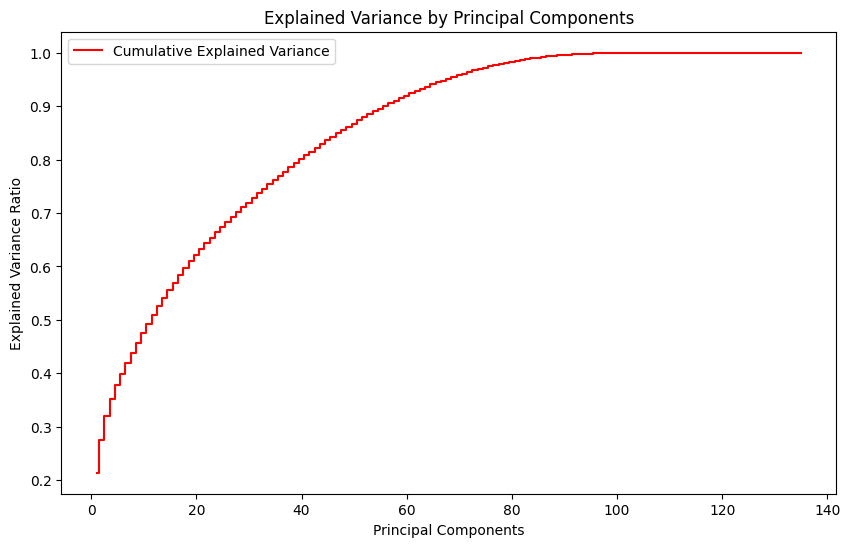

In [32]:
# try pca
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(vectorized_df_scaled)

# Step 3: Explained Variance Ratio
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

# Step 4: Plot the explained variance ratio
plt.figure(figsize=(10, 6))
plt.step(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, where='mid', label='Cumulative Explained Variance', color='red')

plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance by Principal Components')
plt.legend(loc='best')
plt.show()


In [33]:
num_components = np.argmax(cumulative_variance_ratio >= 0.95) + 1
print(f"Number of components for 95% variance: {num_components}")

Number of components for 95% variance: 68


In [34]:
print(len(vectorized_df.columns))

135


In [35]:
# reduce to 69-d
pca = PCA(n_components=69)
vectorized_df_reduced = pca.fit_transform(vectorized_df_scaled)

### K-Mean

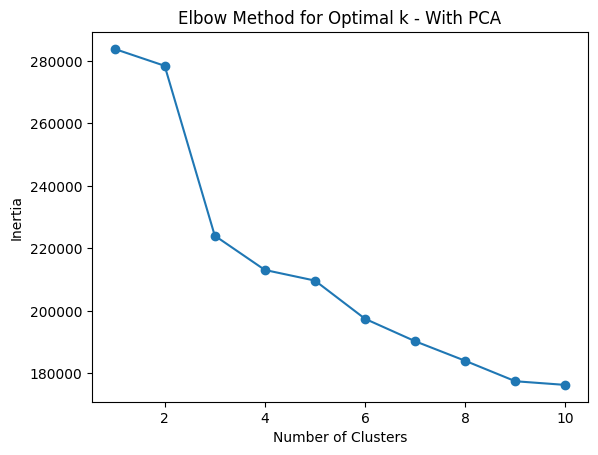

In [36]:
from sklearn.cluster import KMeans

inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(vectorized_df_reduced)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k - With PCA')
plt.show()

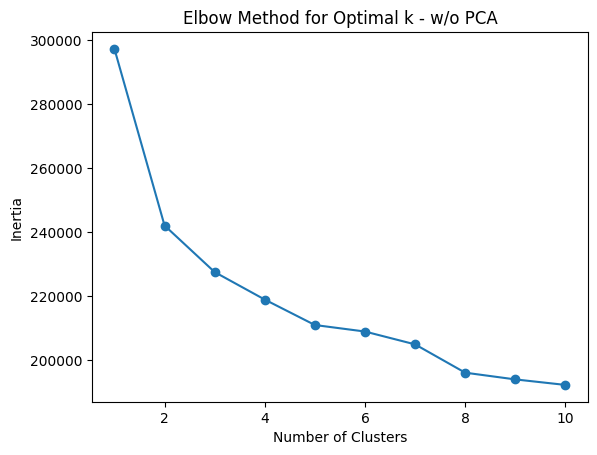

In [37]:
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(vectorized_df_scaled)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k - w/o PCA')
plt.show()

In [38]:
from sklearn.metrics import silhouette_score

# With PCA
kmeans_pca = KMeans(n_clusters=3, random_state=42).fit(vectorized_df_reduced)
silhouette_pca = silhouette_score(vectorized_df_reduced, kmeans_pca.labels_)

# Without PCA
kmeans_original = KMeans(n_clusters=3, random_state=42).fit(vectorized_df_scaled)
silhouette_original = silhouette_score(vectorized_df_scaled, kmeans_original.labels_)

print(f"Silhouette Score with PCA: {silhouette_pca:.2f}")
print(f"Silhouette Score without PCA: {silhouette_original:.2f}")

Silhouette Score with PCA: 0.40
Silhouette Score without PCA: 0.38


In [39]:
# since it shares almost the same result we will proceed with no dim-reduction for clustering (favor intepretability)
# K=3
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(vectorized_df_scaled)

In [40]:
# apply to unscaled version
vectorized_df['Cluster'] = clusters

cluster_summary = vectorized_df.groupby('Cluster').mean()

In [41]:
vectorized_df.groupby('Cluster').count()

,count_row_clash,count_location_clash,mean_lat_clash,mean_long_clash,sum_fatalities_clash,count_actor1_rus_clash,count_actor1_ukr_clash,count_actor2_rus_clash,count_actor2_ukr_clash,is_supported_clash,is_shelling_clash,vehicle_losses_clash,armored_vehicle_losses_clash,car_losses_clash,boat_losses_clash,drone_losses_clash,cannon_losses_clash,uav_losses_clash,mortar_losses_clash,air_forces_supported_clash,artillery_supported_clash,aviation_supported_clash,air_units_supported_clash,count_row_shelling,count_location_shelling,mean_lat_shelling,mean_long_shelling,sum_fatalities_shelling,count_actor1_rus_shelling,count_actor1_ukr_shelling,count_actor2_rus_shelling,count_actor2_ukr_shelling,shelling_flag_shelling,artillery_flag_shelling,missile_flag_shelling,mortar_flag_shelling,missile_type_shelling,anti-tank_shelling,anti-aircraft_shelling,anti-ship_shelling,anti-air_shelling,anti-radar_shelling,grad_shelling,himars_shelling,s-300_shelling,uragan_shelling,iskander_shelling,c-300_shelling,mlrs_shelling,ballistic_shelling,tochka_shelling,smerch_shelling,kalibr_shelling,high-precision_shelling,storm-shadow_shelling,count_row_disrupt,count_location_disrupt,mean_lat_disrupt,mean_long_disrupt,sum_fatalities_disrupt,count_actor1_rus_disrupt,count_actor1_ukr_disrupt,count_actor2_rus_disrupt,count_actor2_ukr_disrupt,n_drone_launched_disrupt,flag_drone_launched_disrupt,n_drone_intercepted_disrupt,flag_drone_intercepted_disrupt,n_kamikaze-drone_launched_disrupt,flag_kamikaze-drone_launched_disrupt,n_kamikaze-drone_intercepted_disrupt,flag_kamikaze-drone_intercepted_disrupt,n_air-bomb_launched_disrupt,flag_air-bomb_launched_disrupt,n_air-bomb_intercepted_disrupt,flag_air-bomb_intercepted_disrupt,n_missile_launched_disrupt,flag_missile_launched_disrupt,n_missile_intercepted_disrupt,flag_missile_intercepted_disrupt,n_uxo_launched_disrupt,flag_uxo_launched_disrupt,n_uxo_intercepted_disrupt,flag_uxo_intercepted_disrupt,n_artillery-shell_launched_disrupt,flag_artillery-shell_launched_disrupt,n_artillery-shell_intercepted_disrupt,flag_artillery-shell_intercepted_disrupt,n_aviation-bomb_launched_disrupt,flag_aviation-bomb_launched_disrupt,n_aviation-bomb_intercepted_disrupt,flag_aviation-bomb_intercepted_disrupt,n_ballistic_launched_disrupt,flag_ballistic_launched_disrupt,n_ballistic_intercepted_disrupt,flag_ballistic_intercepted_disrupt,n_bomb_launched_disrupt,flag_bomb_launched_disrupt,n_bomb_intercepted_disrupt,flag_bomb_intercepted_disrupt,n_explosive_launched_disrupt,flag_explosive_launched_disrupt,n_explosive_intercepted_disrupt,flag_explosive_intercepted_disrupt,n_glider-bomb_launched_disrupt,flag_glider-bomb_launched_disrupt,n_glider-bomb_intercepted_disrupt,flag_glider-bomb_intercepted_disrupt,count_row_airstrike,count_location_airstrike,mean_lat_airstrike,mean_long_airstrike,sum_fatalities_airstrike,count_actor1_rus_airstrike,count_actor1_ukr_airstrike,count_actor2_rus_airstrike,count_actor2_ukr_airstrike,flag_drone_airstrike,flag_drone-strike_airstrike,flag_mortar_airstrike,flag_air-strike_airstrike,flag_kamikaze-drone_airstrike,flag_artillery_airstrike,n_drone-strike_airstrike,n_artillery_airstrike,count_row_regain,count_location_regain,mean_lat_regain,mean_long_regain,sum_fatalities_regain,count_actor1_rus_regain,count_actor1_ukr_regain,count_actor2_rus_regain,count_actor2_ukr_regain,sum_fatalities
Cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,15

In [42]:
cluster_summary

,count_row_clash,count_location_clash,mean_lat_clash,mean_long_clash,sum_fatalities_clash,count_actor1_rus_clash,count_actor1_ukr_clash,count_actor2_rus_clash,count_actor2_ukr_clash,is_supported_clash,is_shelling_clash,vehicle_losses_clash,armored_vehicle_losses_clash,car_losses_clash,boat_losses_clash,drone_losses_clash,cannon_losses_clash,uav_losses_clash,mortar_losses_clash,air_forces_supported_clash,artillery_supported_clash,aviation_supported_clash,air_units_supported_clash,count_row_shelling,count_location_shelling,mean_lat_shelling,mean_long_shelling,sum_fatalities_shelling,count_actor1_rus_shelling,count_actor1_ukr_shelling,count_actor2_rus_shelling,count_actor2_ukr_shelling,shelling_flag_shelling,artillery_flag_shelling,missile_flag_shelling,mortar_flag_shelling,missile_type_shelling,anti-tank_shelling,anti-aircraft_shelling,anti-ship_shelling,anti-air_shelling,anti-radar_shelling,grad_shelling,himars_shelling,s-300_shelling,uragan_shelling,iskander_shelling,c-300_shelling,mlrs_shelling,ballistic_shelling,tochka_shelling,smerch_shelling,kalibr_shelling,high-precision_shelling,storm-shadow_shelling,count_row_disrupt,count_location_disrupt,mean_lat_disrupt,mean_long_disrupt,sum_fatalities_disrupt,count_actor1_rus_disrupt,count_actor1_ukr_disrupt,count_actor2_rus_disrupt,count_actor2_ukr_disrupt,n_drone_launched_disrupt,flag_drone_launched_disrupt,n_drone_intercepted_disrupt,flag_drone_intercepted_disrupt,n_kamikaze-drone_launched_disrupt,flag_kamikaze-drone_launched_disrupt,n_kamikaze-drone_intercepted_disrupt,flag_kamikaze-drone_intercepted_disrupt,n_air-bomb_launched_disrupt,flag_air-bomb_launched_disrupt,n_air-bomb_intercepted_disrupt,flag_air-bomb_intercepted_disrupt,n_missile_launched_disrupt,flag_missile_launched_disrupt,n_missile_intercepted_disrupt,flag_missile_intercepted_disrupt,n_uxo_launched_disrupt,flag_uxo_launched_disrupt,n_uxo_intercepted_disrupt,flag_uxo_intercepted_disrupt,n_artillery-shell_launched_disrupt,flag_artillery-shell_launched_disrupt,n_artillery-shell_intercepted_disrupt,flag_artillery-shell_intercepted_disrupt,n_aviation-bomb_launched_disrupt,flag_aviation-bomb_launched_disrupt,n_aviation-bomb_intercepted_disrupt,flag_aviation-bomb_intercepted_disrupt,n_ballistic_launched_disrupt,flag_ballistic_launched_disrupt,n_ballistic_intercepted_disrupt,flag_ballistic_intercepted_disrupt,n_bomb_launched_disrupt,flag_bomb_launched_disrupt,n_bomb_intercepted_disrupt,flag_bomb_intercepted_disrupt,n_explosive_launched_disrupt,flag_explosive_launched_disrupt,n_explosive_intercepted_disrupt,flag_explosive_intercepted_disrupt,n_glider-bomb_launched_disrupt,flag_glider-bomb_launched_disrupt,n_glider-bomb_intercepted_disrupt,flag_glider-bomb_intercepted_disrupt,count_row_airstrike,count_location_airstrike,mean_lat_airstrike,mean_long_airstrike,sum_fatalities_airstrike,count_actor1_rus_airstrike,count_actor1_ukr_airstrike,count_actor2_rus_airstrike,count_actor2_ukr_airstrike,flag_drone_airstrike,flag_drone-strike_airstrike,flag_mortar_airstrike,flag_air-strike_airstrike,flag_kamikaze-drone_airstrike,flag_artillery_airstrike,n_drone-strike_airstrike,n_artillery_airstrike,count_row_regain,count_location_regain,mean_lat_regain,mean_long_regain,sum_fatalities_regain,count_actor1_rus_regain,count_actor1_ukr_regain,count_actor2_rus_regain,count_actor2_ukr_regain,sum_fatalities
Cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,14.722404,14.708687,47.474422,37.646544,1.338341,0.276290,7.735467,0.096669,6.960810,0.000653,0.018942,0.013063,0.000000,0.020901,0.00000,0.010451,0.777270,0.000000,47.399086,0.000000,0.000000,0.000,0.000000,15.320705,15.278903,47.772755,37.776899,0.421293,0.598302,8.345526,0.071195,3.082299,0.101241,0.235140,0.127368,0.753103,0.124102,0.116264,0.000000,0.000653,0.000000,0.000000,0.003919,0.000000,0.000653,0.000000,0.000000,0.000000,0.000000,0.001306,0.000653,0.000000,0.000000,0.000000,0.000000,0.25538

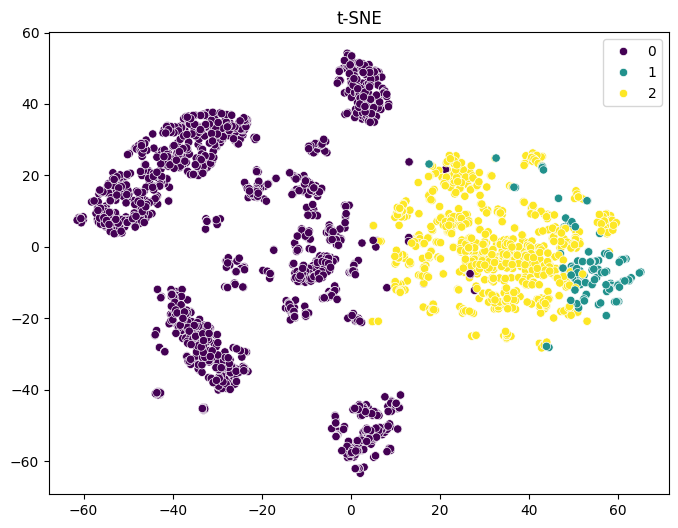

In [43]:
from sklearn.manifold import TSNE

# Apply t-SNE to reduce dimensionality
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(vectorized_df_scaled)

# Scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=tsne_results[:, 0], y=tsne_results[:, 1], hue=vectorized_df['Cluster'], palette='viridis')
plt.title("t-SNE")
plt.legend(loc="best")
plt.show()

/Users/ssutthiboriban/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/ssutthiboriban/Library/Python/3.9/lib/python/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


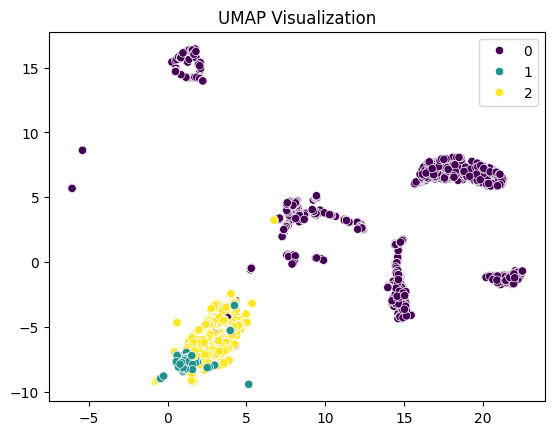

In [44]:
import umap.umap_ as umap

umap_reducer = umap.UMAP(n_components=2, random_state=42)
umap_results = umap_reducer.fit_transform(vectorized_df_scaled)

sns.scatterplot(x=umap_results[:, 0], y=umap_results[:, 1], hue=vectorized_df['Cluster'], palette='viridis')
plt.title("UMAP Visualization")
plt.legend(loc="best")
plt.show()

Meaningful clustering, seems like 0 (low intensity) has sub-clusters, 1 (high) and 2 (medium) have an overlap boundary. Global structure of UMAP makes sense

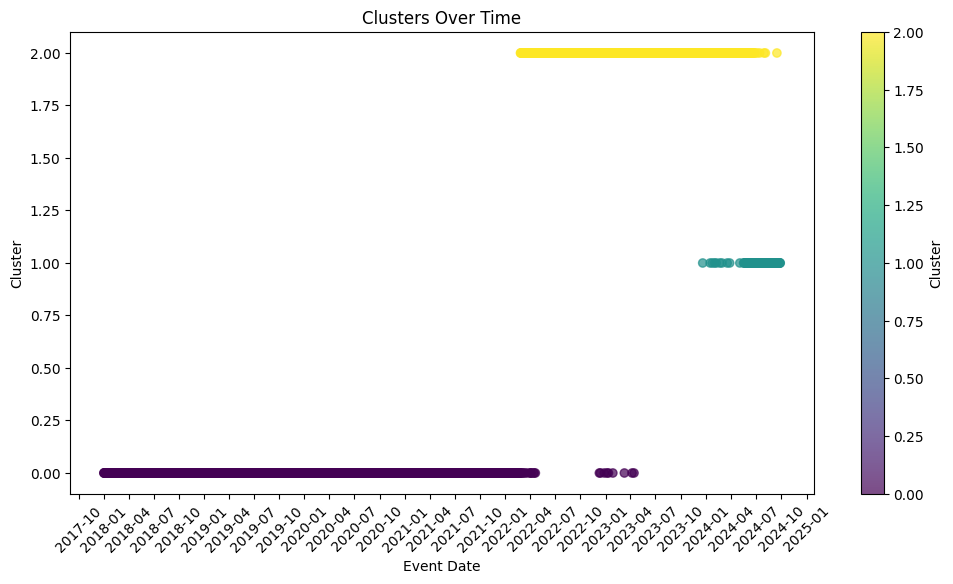

In [45]:
import matplotlib.dates as mdates

vectorized_df['event_date'] = event_dates
vectorized_df['event_date'] = pd.to_datetime(vectorized_df['event_date'])

# Sort by event_date
vectorized_df = vectorized_df.sort_values(by='event_date')

plt.figure(figsize=(12, 6))

# Scatter plot: event_date vs cluster
plt.scatter(vectorized_df['event_date'], vectorized_df['Cluster'], c=vectorized_df['Cluster'], cmap='viridis', alpha=0.7)
plt.colorbar(label='Cluster')
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # Show ticks every 3 months
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m')) 
plt.title('Clusters Over Time')
plt.xlabel('Event Date')
plt.ylabel('Cluster')
plt.xticks(rotation=45)
plt.show()

In [46]:
# Calculate the range (max - min) of each feature across clusters
feature_variances = cluster_summary.max() - cluster_summary.min()

# Sort features by variance
top_features = feature_variances.sort_values(ascending=False).head(10)
print("Top Differentiating Features:\n", top_features)

Top Differentiating Features:
 n_artillery_airstrike          333.633333
sum_fatalities                 244.712323
sum_fatalities_clash           207.669992
n_drone-strike_airstrike       178.591667
n_drone_intercepted_disrupt     90.077972
count_row_airstrike             80.234030
count_location_airstrike        79.234030
count_row_shelling              75.412545
count_location_shelling         73.838963
count_actor1_rus_shelling       71.744130
dtype: float64


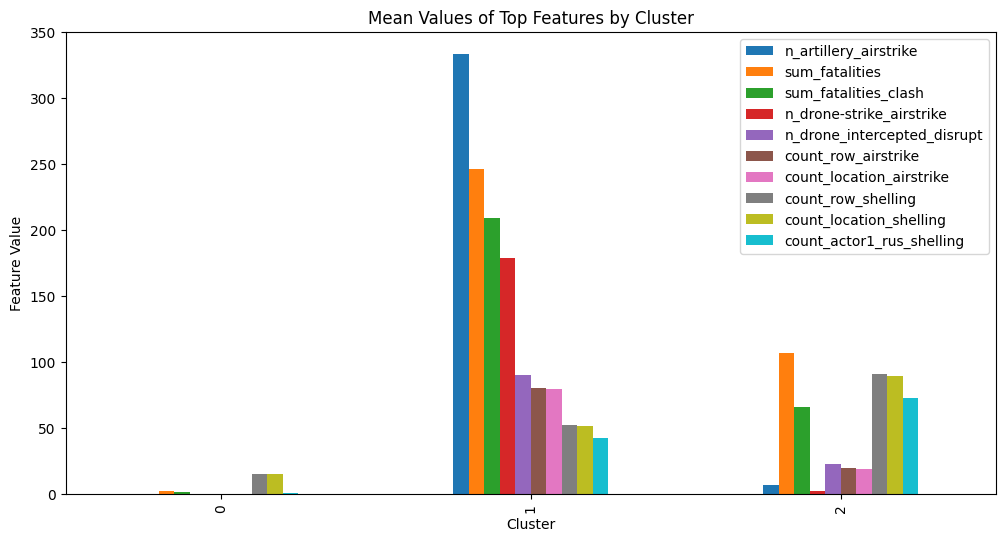

In [47]:
# Select top features for visualization
selected_features = top_features.index

# Plot mean values for each feature across clusters
cluster_summary[selected_features].plot(kind='bar', figsize=(12, 6))
plt.title("Mean Values of Top Features by Cluster")
plt.xlabel("Cluster")
plt.ylabel("Feature Value")
plt.legend(loc="upper right")
plt.show()

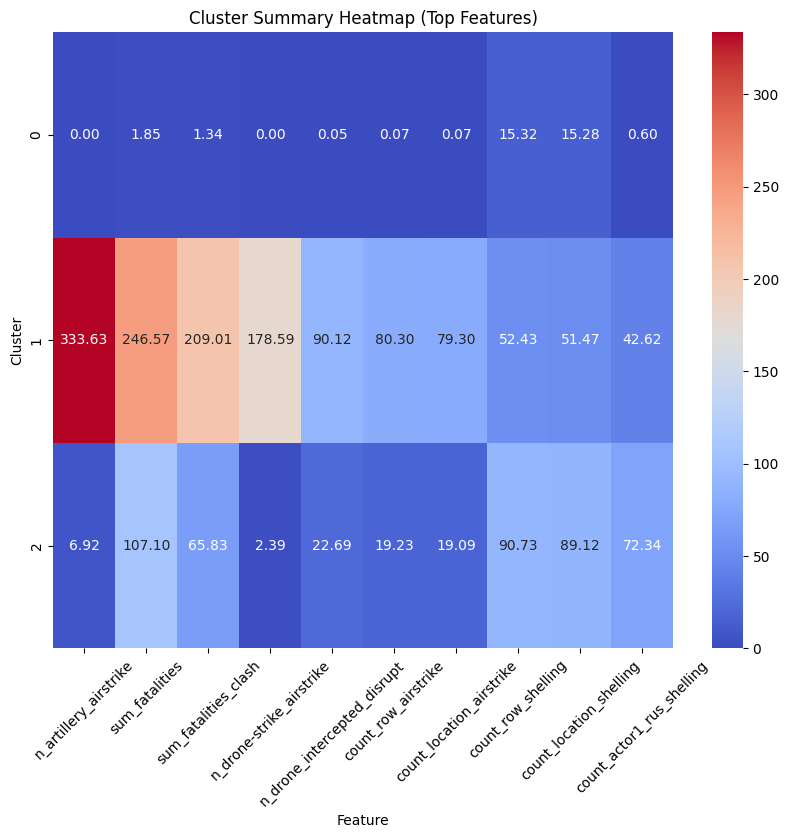

In [48]:
# Plot a heatmap for top features
plt.figure(figsize=(10, 8))
sns.heatmap(cluster_summary[selected_features], annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Cluster Summary Heatmap (Top Features)")
plt.xlabel("Feature")
plt.xticks(rotation=45)
plt.ylabel("Cluster")
plt.show()

Try trimmed mean for visualization

In [49]:
from scipy.stats import trim_mean

# Define a function to compute trimmed mean for each feature in the cluster
def compute_trimmed_mean(df, trim_percent):
    return df.apply(lambda x: trim_mean(x, proportiontocut=trim_percent))

trim_percent = 0.1  
cluster_trimmed_summary = vectorized_df.drop(columns=['event_date']).groupby('Cluster').apply(lambda group: compute_trimmed_mean(group.iloc[:, :-1], trim_percent))

cluster_trimmed_summary

/var/folders/m1/y50gr9tn5796vpljdx0my4sc0000gn/T/ipykernel_28989/1241627739.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  cluster_trimmed_summary = vectorized_df.drop(columns=['event_date']).groupby('Cluster').apply(lambda group: compute_trimmed_mean(group.iloc[:, :-1], trim_percent))


,count_row_clash,count_location_clash,mean_lat_clash,mean_long_clash,sum_fatalities_clash,count_actor1_rus_clash,count_actor1_ukr_clash,count_actor2_rus_clash,count_actor2_ukr_clash,is_supported_clash,is_shelling_clash,vehicle_losses_clash,armored_vehicle_losses_clash,car_losses_clash,boat_losses_clash,drone_losses_clash,cannon_losses_clash,uav_losses_clash,mortar_losses_clash,air_forces_supported_clash,artillery_supported_clash,aviation_supported_clash,air_units_supported_clash,count_row_shelling,count_location_shelling,mean_lat_shelling,mean_long_shelling,sum_fatalities_shelling,count_actor1_rus_shelling,count_actor1_ukr_shelling,count_actor2_rus_shelling,count_actor2_ukr_shelling,shelling_flag_shelling,artillery_flag_shelling,missile_flag_shelling,mortar_flag_shelling,missile_type_shelling,anti-tank_shelling,anti-aircraft_shelling,anti-ship_shelling,anti-air_shelling,anti-radar_shelling,grad_shelling,himars_shelling,s-300_shelling,uragan_shelling,iskander_shelling,c-300_shelling,mlrs_shelling,ballistic_shelling,tochka_shelling,smerch_shelling,kalibr_shelling,high-precision_shelling,storm-shadow_shelling,count_row_disrupt,count_location_disrupt,mean_lat_disrupt,mean_long_disrupt,sum_fatalities_disrupt,count_actor1_rus_disrupt,count_actor1_ukr_disrupt,count_actor2_rus_disrupt,count_actor2_ukr_disrupt,n_drone_launched_disrupt,flag_drone_launched_disrupt,n_drone_intercepted_disrupt,flag_drone_intercepted_disrupt,n_kamikaze-drone_launched_disrupt,flag_kamikaze-drone_launched_disrupt,n_kamikaze-drone_intercepted_disrupt,flag_kamikaze-drone_intercepted_disrupt,n_air-bomb_launched_disrupt,flag_air-bomb_launched_disrupt,n_air-bomb_intercepted_disrupt,flag_air-bomb_intercepted_disrupt,n_missile_launched_disrupt,flag_missile_launched_disrupt,n_missile_intercepted_disrupt,flag_missile_intercepted_disrupt,n_uxo_launched_disrupt,flag_uxo_launched_disrupt,n_uxo_intercepted_disrupt,flag_uxo_intercepted_disrupt,n_artillery-shell_launched_disrupt,flag_artillery-shell_launched_disrupt,n_artillery-shell_intercepted_disrupt,flag_artillery-shell_intercepted_disrupt,n_aviation-bomb_launched_disrupt,flag_aviation-bomb_launched_disrupt,n_aviation-bomb_intercepted_disrupt,flag_aviation-bomb_intercepted_disrupt,n_ballistic_launched_disrupt,flag_ballistic_launched_disrupt,n_ballistic_intercepted_disrupt,flag_ballistic_intercepted_disrupt,n_bomb_launched_disrupt,flag_bomb_launched_disrupt,n_bomb_intercepted_disrupt,flag_bomb_intercepted_disrupt,n_explosive_launched_disrupt,flag_explosive_launched_disrupt,n_explosive_intercepted_disrupt,flag_explosive_intercepted_disrupt,n_glider-bomb_launched_disrupt,flag_glider-bomb_launched_disrupt,n_glider-bomb_intercepted_disrupt,flag_glider-bomb_intercepted_disrupt,count_row_airstrike,count_location_airstrike,mean_lat_airstrike,mean_long_airstrike,sum_fatalities_airstrike,count_actor1_rus_airstrike,count_actor1_ukr_airstrike,count_actor2_rus_airstrike,count_actor2_ukr_airstrike,flag_drone_airstrike,flag_drone-strike_airstrike,flag_mortar_airstrike,flag_air-strike_airstrike,flag_kamikaze-drone_airstrike,flag_artillery_airstrike,n_drone-strike_airstrike,n_artillery_airstrike,count_row_regain,count_location_regain,mean_lat_regain,mean_long_regain,sum_fatalities_regain,count_actor1_rus_regain,count_actor1_ukr_regain,count_actor2_rus_regain,count_actor2_ukr_regain,sum_fatalities
Cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,13.946122,13.932245,47.957325,37.983936,0.422857,0.000000,7.021224,0.000000,6.428571,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.054694,0.00000,0.000,0.00000,0.0000,14.172245,14.155918,48.128961,38.070518,0.02449,0.000000,7.720000,0.000000,2.651429,0.001633,0.16898,0.034286,0.816327,0.030204,0.020408,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.118367,0.118367,4.733951,3.174224,0.0,0.000000,0.037551,0.000000,0.041633,0.

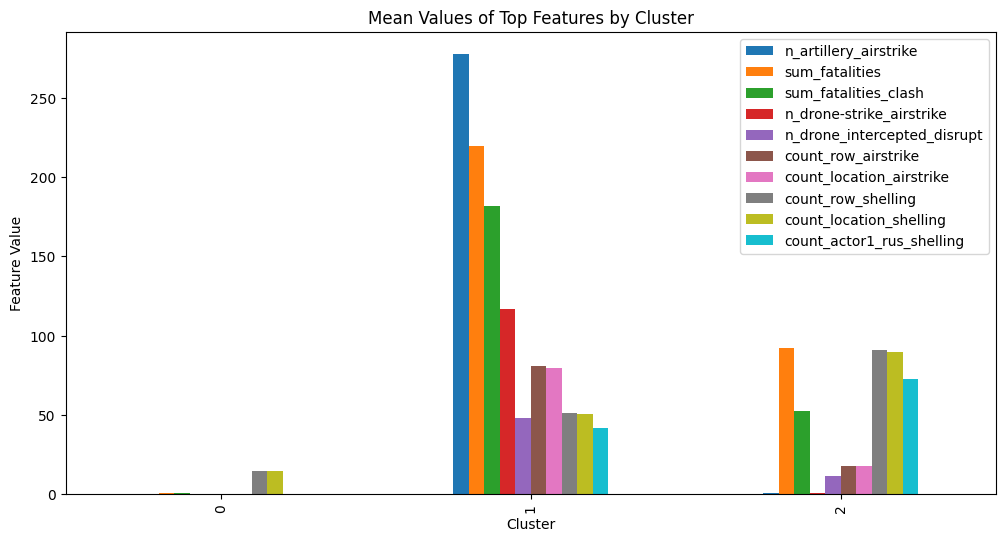

In [50]:
# Plot mean values for each feature across clusters
cluster_trimmed_summary[selected_features].plot(kind='bar', figsize=(12, 6))
plt.title("Mean Values of Top Features by Cluster")
plt.xlabel("Cluster")
plt.ylabel("Feature Value")
plt.legend(loc="upper right")
plt.show()

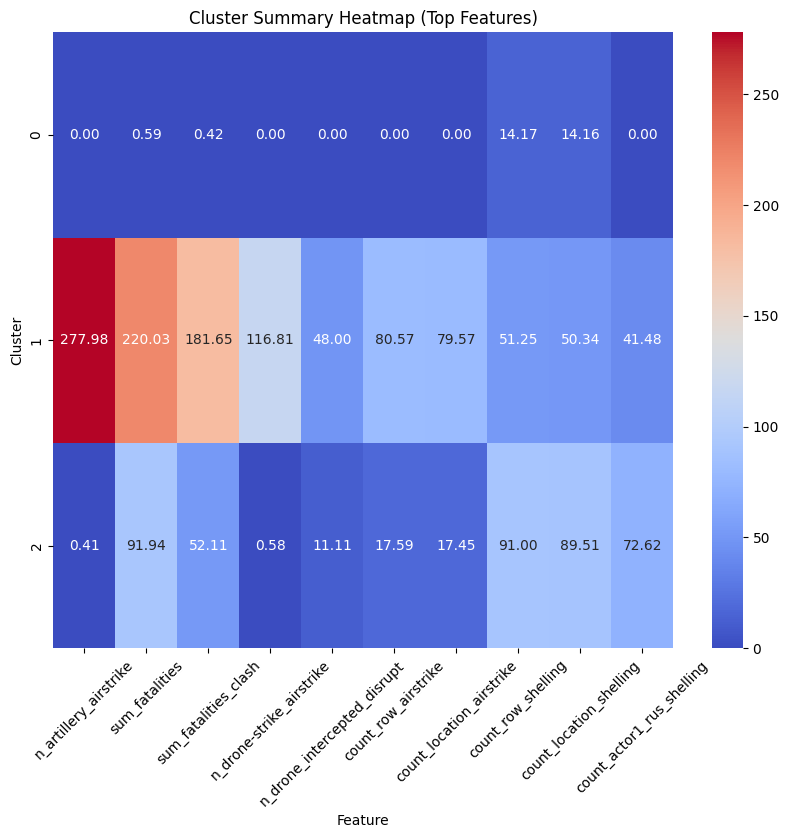

In [51]:
# Plot a heatmap for top features
plt.figure(figsize=(10, 8))
sns.heatmap(cluster_trimmed_summary[selected_features], annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Cluster Summary Heatmap (Top Features)")
plt.xlabel("Feature")
plt.xticks(rotation=45)
plt.ylabel("Cluster")
plt.show()

seems like no ugly outliers

### DBSCAN

In [52]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.5, min_samples=5)  # Tune `eps` and `min_samples`
clusters = dbscan.fit_predict(vectorized_df_scaled)

# Add cluster labels to the DataFrame
vectorized_df['Cluster_DBSCAN'] = clusters

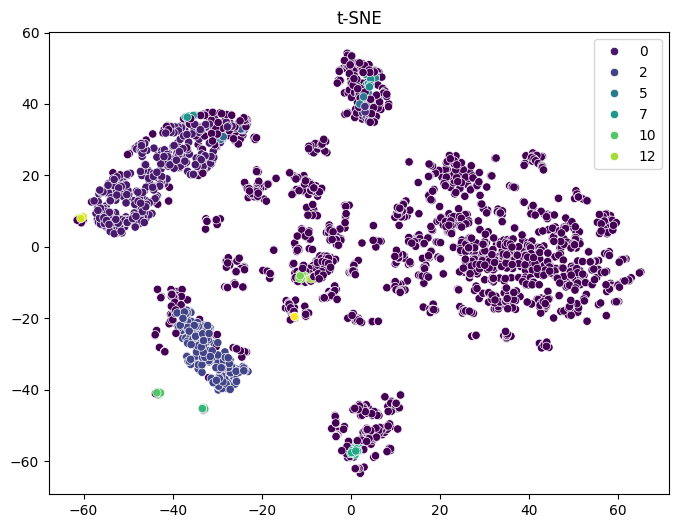

In [53]:
from sklearn.manifold import TSNE

# Apply t-SNE to reduce dimensionality
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(vectorized_df_scaled)

# Scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=tsne_results[:, 0], y=tsne_results[:, 1], hue=vectorized_df['Cluster_DBSCAN'], palette='viridis')
plt.title("t-SNE")
plt.legend(loc="best")
plt.show()

/Users/ssutthiboriban/Library/Python/3.9/lib/python/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


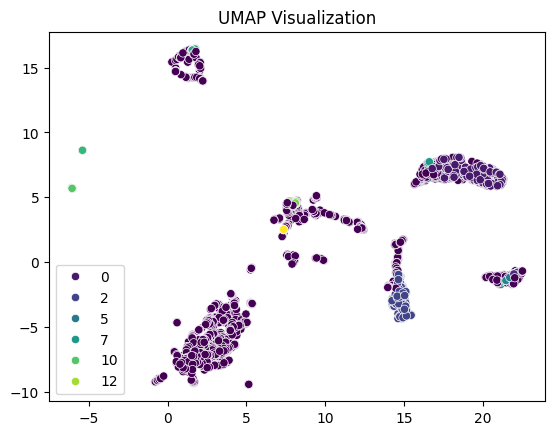

In [54]:
import umap.umap_ as umap

umap_reducer = umap.UMAP(n_components=2, random_state=42)
umap_results = umap_reducer.fit_transform(vectorized_df_scaled)

sns.scatterplot(x=umap_results[:, 0], y=umap_results[:, 1], hue=vectorized_df['Cluster_DBSCAN'], palette='viridis')
plt.title("UMAP Visualization")
plt.legend(loc="best")
plt.show()

In [55]:
vectorized_df.groupby(['Cluster_DBSCAN', 'Cluster']).count()

count_row_clash  count_location_clash  mean_lat_clash  \
Cluster_DBSCAN Cluster                                                          
-1             0                    883                   883             883   
               1                    120                   120             120   
               2                    806                   806             806   
 0             0                    339                   339             339   
 1             0                     22                    22              22   
 2             0                    187                   187             187   
 3             0                      5                     5               5   
 4             0                      6                     6               6   
 5             0                      7                     7               7   
 6             0                      8                     8               8   
 7             0                      6                     6               6   
 8             0                     22                    22              22   
 9             0                      6                     6               6   
 10            0                     13                    13              13   
 11            0                     13                    13              13   
 12            0                      4                     4               4   
 13            0                      5                     5               5   
 14            0                      5                     5               5   

                        mean_long_clash  sum_fatalities_clash  \
Cluster_DBSCAN Cluster                                          
-1             0                    883                   883   
               1                    120                   120   
               2                    806                   806   
 0             0                    339                   339   
 1             0                     22                    22   
 2             0                    187                   187   
 3             0                      5                     5   
 4             0                      6                     6   
 5             0                      7                     7   
 6             0                      8                     8   
 7             0                      6                     6   
 8             0                     22                    22   
 9             0                      6                     6   
 10            0                     13                    13   
 11            0                     13                    13   
 12            0                      4                     4   
 13            0                      5                     5   
 14            0                      5                     5   

                        count_actor1_rus_clash  count_actor1_ukr_clash  \
Cluster_DBSCAN Cluster                                                   
-1             0                           883                     883   
               1                           120                     120   
               2                           806                     806   
 0             0                           339                     339   
 1             0                            22                      22   
 2             0                           187                     187   
 3             0                             5                       5   
 4             0                             6                       6   
 5             0                             7                       7   
 6             0                             8                       8   
 7             0                             6                       6   
 8             0                            22                      22   
 9             0                             6                    

treat 1 and 2 as noises.. lol

### Agglomerative Clustering

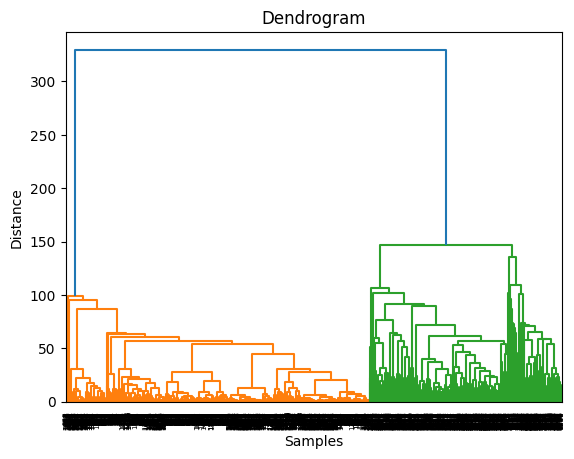

In [56]:
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering

# Create linkage matrix and plot dendrogram
linkage_matrix = linkage(vectorized_df_scaled, method='ward')
dendrogram(linkage_matrix)
plt.title('Dendrogram')
plt.xlabel('Samples')
plt.ylabel('Distance')
plt.show()

# Perform Agglomerative Clustering
agglomerative = AgglomerativeClustering(n_clusters=3, linkage='ward')
clusters = agglomerative.fit_predict(vectorized_df_scaled)
vectorized_df['Cluster_Hierarchical'] = clusters

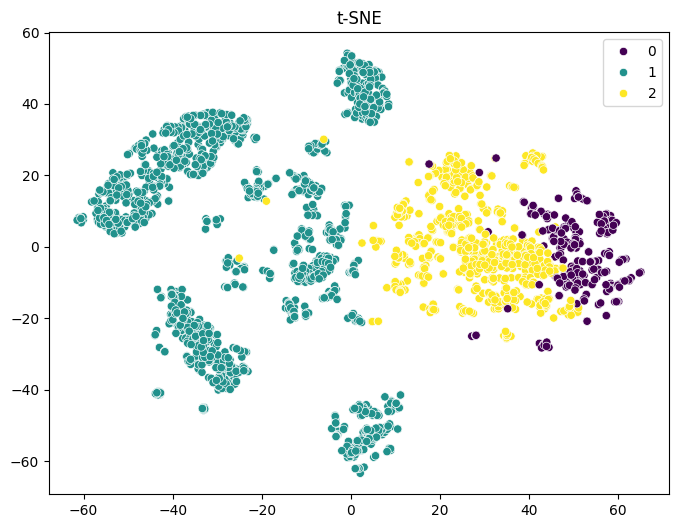

In [57]:
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(vectorized_df_scaled)

# Scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=tsne_results[:, 0], y=tsne_results[:, 1], hue=vectorized_df['Cluster_Hierarchical'], palette='viridis')
plt.title("t-SNE")
plt.legend(loc="best")
plt.show()

/Users/ssutthiboriban/Library/Python/3.9/lib/python/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


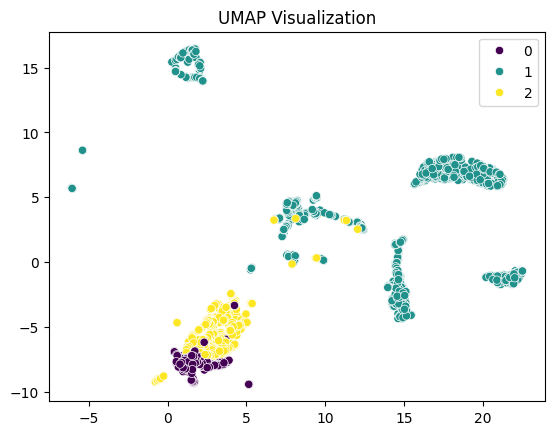

In [58]:
umap_reducer = umap.UMAP(n_components=2, random_state=42)
umap_results = umap_reducer.fit_transform(vectorized_df_scaled)

sns.scatterplot(x=umap_results[:, 0], y=umap_results[:, 1], hue=vectorized_df['Cluster_Hierarchical'], palette='viridis')
plt.title("UMAP Visualization")
plt.legend(loc="best")
plt.show()

In [59]:
vectorized_df.groupby(['Cluster_Hierarchical', 'Cluster']).count()

count_row_clash  count_location_clash  \
Cluster_Hierarchical Cluster                                          
0                    1                    111                   111   
                     2                    153                   153   
1                    0                   1507                  1507   
2                    0                     24                    24   
                     1                      9                     9   
                     2                    653                   653   

                              mean_lat_clash  mean_long_clash  \
Cluster_Hierarchical Cluster                                    
0                    1                   111              111   
                     2                   153              153   
1                    0                  1507             1507   
2                    0                    24               24   
                     1                     9                9   
                     2                   653              653   

                              sum_fatalities_clash  count_actor1_rus_clash  \
Cluster_Hierarchical Cluster                                                 
0                    1                         111                     111   
                     2                         153                     153   
1                    0                        1507                    1507   
2                    0                          24                      24   
                     1                           9                       9   
                     2                         653                     653   

                              count_actor1_ukr_clash  count_actor2_rus_clash  \
Cluster_Hierarchical Cluster                                                   
0                    1                           111                     111   
                     2                           153                     153   
1                    0                          1507                    1507   
2                    0                            24                      24   
                     1                             9                       9   
                     2                           653                     653   

                              count_actor2_ukr_clash  is_supported_clash  \
Cluster_Hierarchical Cluster                                               
0                    1                           111                 111   
                     2                           153                 153   
1                    0                          1507                1507   
2                    0                            24                  24   
                     1                             9                   9   
                     2                           653                 653   

                              is_shelling_clash  vehicle_losses_clash  \
Cluster_Hierarchical Cluster                                            
0                    1                      111                   111   
                     2                      153                   153   
1                    0                     1507                  1507   
2                    0                       24                    24   
                     1                        9                     9   
                     2                      653                   653   

                              armored_vehicle_losses_clash  car_losses_clash  \
Cluster_Hierarchical Cluster                                                   
0                    1                                 111               111   
                     2                                 153               153   
1                    0                                1507              1507   
2                    0                                  24                24   


[0 = medium, 2 = high, 1 = low, based from k-mean] But seems like there are medium in Cluster 2 too.

In [60]:
hier_cluster_summary = vectorized_df.drop(columns=['event_date', 'Cluster_DBSCAN']).groupby('Cluster_Hierarchical').mean()
hier_cluster_summary

,count_row_clash,count_location_clash,mean_lat_clash,mean_long_clash,sum_fatalities_clash,count_actor1_rus_clash,count_actor1_ukr_clash,count_actor2_rus_clash,count_actor2_ukr_clash,is_supported_clash,is_shelling_clash,vehicle_losses_clash,armored_vehicle_losses_clash,car_losses_clash,boat_losses_clash,drone_losses_clash,cannon_losses_clash,uav_losses_clash,mortar_losses_clash,air_forces_supported_clash,artillery_supported_clash,aviation_supported_clash,air_units_supported_clash,count_row_shelling,count_location_shelling,mean_lat_shelling,mean_long_shelling,sum_fatalities_shelling,count_actor1_rus_shelling,count_actor1_ukr_shelling,count_actor2_rus_shelling,count_actor2_ukr_shelling,shelling_flag_shelling,artillery_flag_shelling,missile_flag_shelling,mortar_flag_shelling,missile_type_shelling,anti-tank_shelling,anti-aircraft_shelling,anti-ship_shelling,anti-air_shelling,anti-radar_shelling,grad_shelling,himars_shelling,s-300_shelling,uragan_shelling,iskander_shelling,c-300_shelling,mlrs_shelling,ballistic_shelling,tochka_shelling,smerch_shelling,kalibr_shelling,high-precision_shelling,storm-shadow_shelling,count_row_disrupt,count_location_disrupt,mean_lat_disrupt,mean_long_disrupt,sum_fatalities_disrupt,count_actor1_rus_disrupt,count_actor1_ukr_disrupt,count_actor2_rus_disrupt,count_actor2_ukr_disrupt,n_drone_launched_disrupt,flag_drone_launched_disrupt,n_drone_intercepted_disrupt,flag_drone_intercepted_disrupt,n_kamikaze-drone_launched_disrupt,flag_kamikaze-drone_launched_disrupt,n_kamikaze-drone_intercepted_disrupt,flag_kamikaze-drone_intercepted_disrupt,n_air-bomb_launched_disrupt,flag_air-bomb_launched_disrupt,n_air-bomb_intercepted_disrupt,flag_air-bomb_intercepted_disrupt,n_missile_launched_disrupt,flag_missile_launched_disrupt,n_missile_intercepted_disrupt,flag_missile_intercepted_disrupt,n_uxo_launched_disrupt,flag_uxo_launched_disrupt,n_uxo_intercepted_disrupt,flag_uxo_intercepted_disrupt,n_artillery-shell_launched_disrupt,flag_artillery-shell_launched_disrupt,n_artillery-shell_intercepted_disrupt,flag_artillery-shell_intercepted_disrupt,n_aviation-bomb_launched_disrupt,flag_aviation-bomb_launched_disrupt,n_aviation-bomb_intercepted_disrupt,flag_aviation-bomb_intercepted_disrupt,n_ballistic_launched_disrupt,flag_ballistic_launched_disrupt,n_ballistic_intercepted_disrupt,flag_ballistic_intercepted_disrupt,n_bomb_launched_disrupt,flag_bomb_launched_disrupt,n_bomb_intercepted_disrupt,flag_bomb_intercepted_disrupt,n_explosive_launched_disrupt,flag_explosive_launched_disrupt,n_explosive_intercepted_disrupt,flag_explosive_intercepted_disrupt,n_glider-bomb_launched_disrupt,flag_glider-bomb_launched_disrupt,n_glider-bomb_intercepted_disrupt,flag_glider-bomb_intercepted_disrupt,count_row_airstrike,count_location_airstrike,mean_lat_airstrike,mean_long_airstrike,sum_fatalities_airstrike,count_actor1_rus_airstrike,count_actor1_ukr_airstrike,count_actor2_rus_airstrike,count_actor2_ukr_airstrike,flag_drone_airstrike,flag_drone-strike_airstrike,flag_mortar_airstrike,flag_air-strike_airstrike,flag_kamikaze-drone_airstrike,flag_artillery_airstrike,n_drone-strike_airstrike,n_artillery_airstrike,count_row_regain,count_location_regain,mean_lat_regain,mean_long_regain,sum_fatalities_regain,count_actor1_rus_regain,count_actor1_ukr_regain,count_actor2_rus_regain,count_actor2_ukr_regain,sum_fatalities,Cluster
Cluster_Hierarchical,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,41.208333,40.655303,48.506516,37.169530,149.295455,36.746212,4.412879,4.446970,36.738636,0.662879,0.371212,28.257576,7.670455,18.549242,0.931818,32.337121,0.537879,1.428030,0.715909,0.344697,0.284091,0.098485,0.200758,71.632576,70.484848,49.321256,35.434262,22.087121,56.587121,15.015152,7.121212,12.094697,0.397727,0.981061,0.746212,0.867424,0.462121,0.007576,0.015152,0.000000,0.015152,0.003788,0.015152,0.030303,0.094697,0.007576,0.113636,0.007576,0.034091,0.071970,0.011364,0.00757

In [61]:
# Calculate the range (max - min) of each feature across clusters
hier_feature_variances = hier_cluster_summary.max() - hier_cluster_summary.min()

# Sort features by variance
hier_top_features = hier_feature_variances.sort_values(ascending=False).head(10)
print("Top Differentiating Features:\n", hier_top_features)
hier_selected_features = hier_top_features.index

Top Differentiating Features:
 sum_fatalities                 181.396041
n_artillery_airstrike          155.757576
sum_fatalities_clash           148.418879
n_drone-strike_airstrike        82.034091
count_row_shelling              74.910759
count_location_shelling         73.283315
count_actor1_rus_shelling       71.745042
n_drone_intercepted_disrupt     56.705458
count_row_airstrike             51.425238
count_location_airstrike        50.853268
dtype: float64


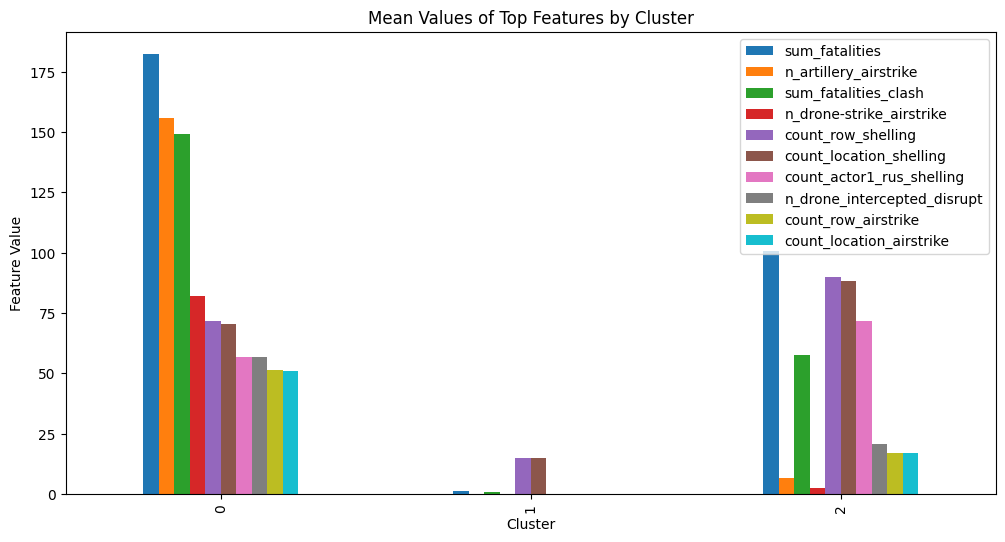

In [62]:
# Plot mean values for each feature across clusters
hier_cluster_summary[hier_selected_features].plot(kind='bar', figsize=(12, 6))
plt.title("Mean Values of Top Features by Cluster")
plt.xlabel("Cluster")
plt.ylabel("Feature Value")
plt.legend(loc="upper right")
plt.show()

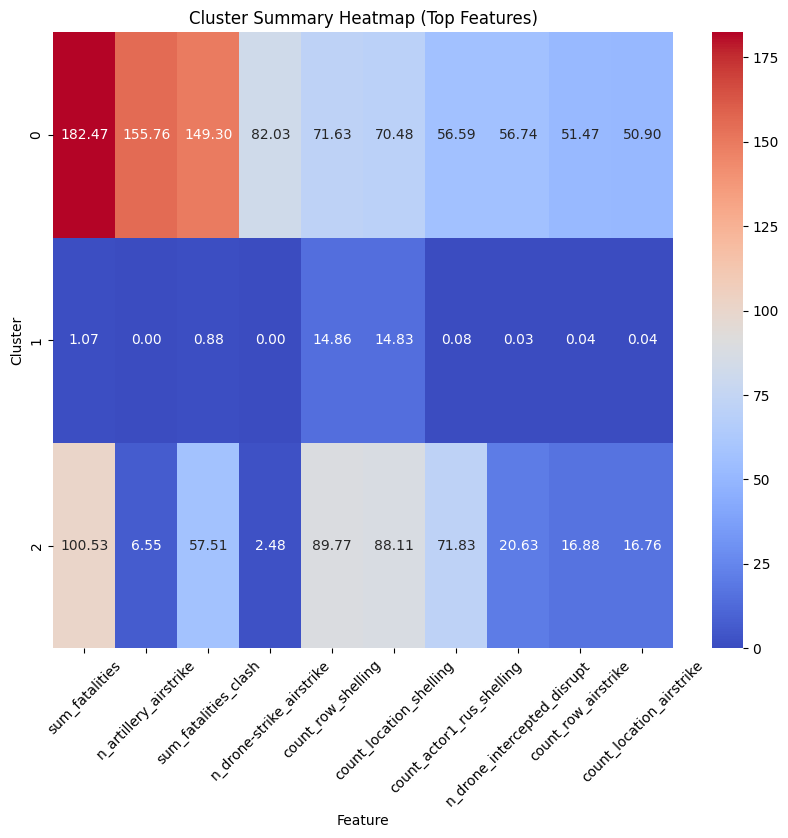

In [63]:
# Plot a heatmap for top features
plt.figure(figsize=(10, 8))
sns.heatmap(hier_cluster_summary[hier_selected_features], annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Cluster Summary Heatmap (Top Features)")
plt.xlabel("Feature")
plt.xticks(rotation=45)
plt.ylabel("Cluster")
plt.show()

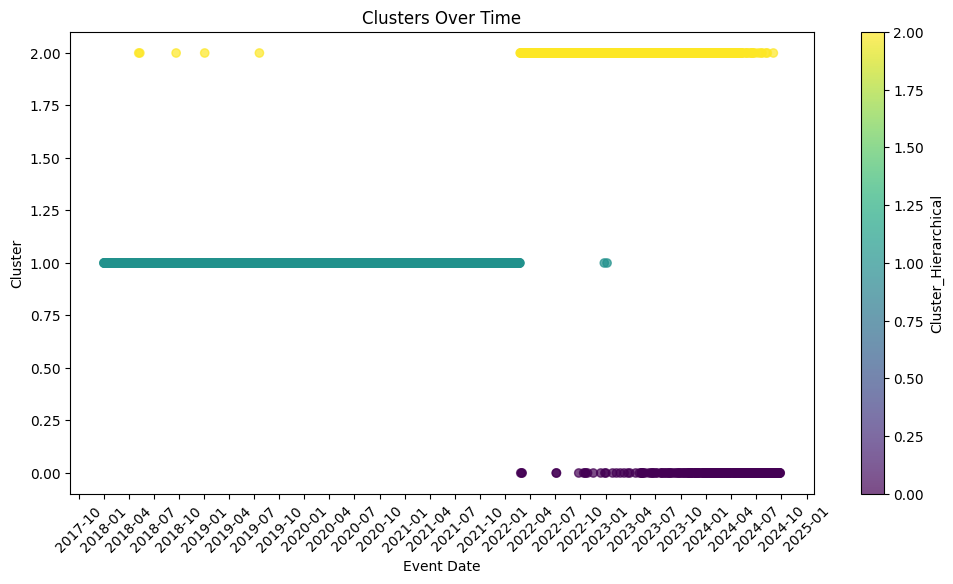

In [64]:
plt.figure(figsize=(12, 6))

# Scatter plot: event_date vs cluster
plt.scatter(vectorized_df['event_date'], vectorized_df['Cluster_Hierarchical'], c=vectorized_df['Cluster_Hierarchical'], cmap='viridis', alpha=0.7)
plt.colorbar(label='Cluster_Hierarchical')
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # Show ticks every 3 months
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m')) 
plt.title('Clusters Over Time')
plt.xlabel('Event Date')
plt.ylabel('Cluster')
plt.xticks(rotation=45)
plt.show()

note: 0 is high, 1 is low, 2 is medium

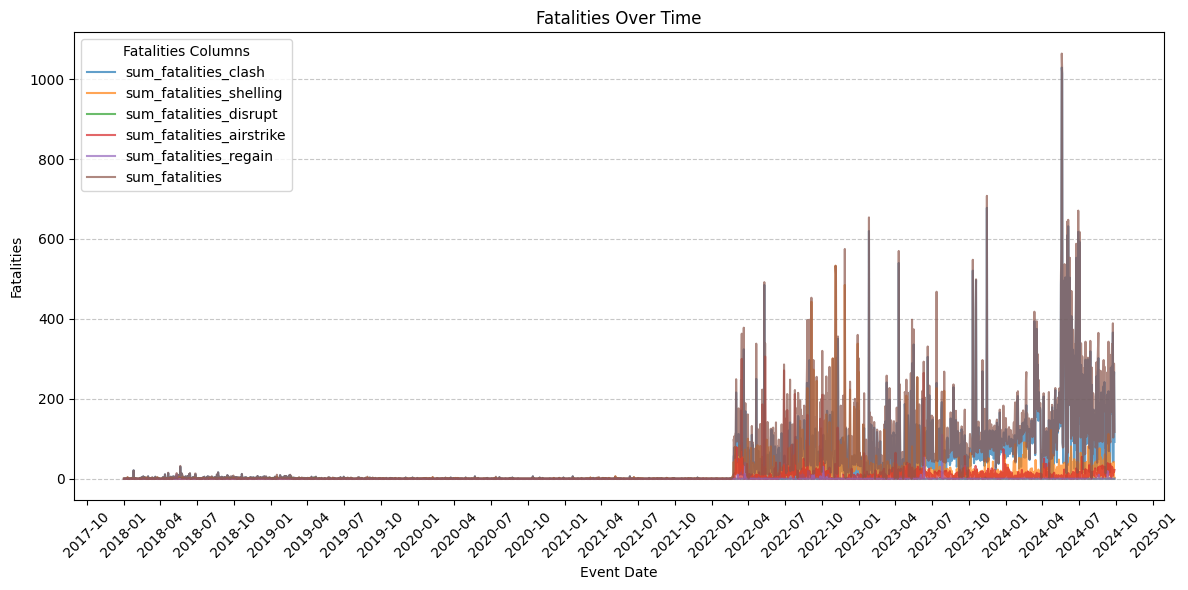

In [83]:
vectorized_df['event_date'] = pd.to_datetime(vectorized_df['event_date'])

# Filter columns containing 'fatalities'
fatalities_columns = [col for col in vectorized_df.columns if 'fatalities' in col]
# fatalities_columns = [col for col in vectorized_df.columns if col == 'sum_fatalities']

# Plot each 'fatalities' column over event_date
plt.figure(figsize=(12, 6))

for col in fatalities_columns:
    plt.plot(vectorized_df['event_date'], vectorized_df[col], label=col, alpha=0.7)

plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # Show ticks every 3 months
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m')) 

# Add labels, legend, and title
plt.title('Fatalities Over Time')
plt.xlabel('Event Date')
plt.ylabel('Fatalities')
plt.xticks(rotation=45)
plt.legend(title='Fatalities Columns', loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

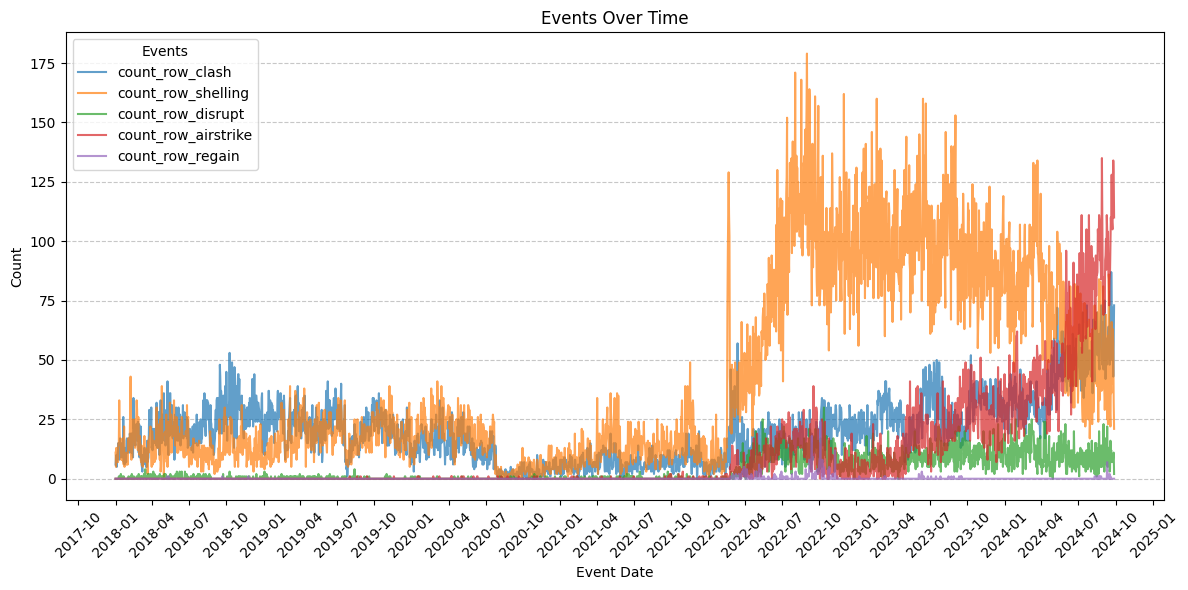

In [69]:
vectorized_df['event_date'] = pd.to_datetime(vectorized_df['event_date'])

selected_columns = [col for col in vectorized_df.columns if 'count_row' in col]

plt.figure(figsize=(12, 6))

for col in selected_columns:
    plt.plot(vectorized_df['event_date'], vectorized_df[col], label=col, alpha=0.7)

plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # Show ticks every 3 months
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m')) 

# Add labels, legend, and title
plt.title('Events Over Time')
plt.xlabel('Event Date')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Events', loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

Thoughts: Airstrike defines high vs medium?

In [71]:
vectorized_df.groupby('Cluster').count()

,count_row_clash,count_location_clash,mean_lat_clash,mean_long_clash,sum_fatalities_clash,count_actor1_rus_clash,count_actor1_ukr_clash,count_actor2_rus_clash,count_actor2_ukr_clash,is_supported_clash,is_shelling_clash,vehicle_losses_clash,armored_vehicle_losses_clash,car_losses_clash,boat_losses_clash,drone_losses_clash,cannon_losses_clash,uav_losses_clash,mortar_losses_clash,air_forces_supported_clash,artillery_supported_clash,aviation_supported_clash,air_units_supported_clash,count_row_shelling,count_location_shelling,mean_lat_shelling,mean_long_shelling,sum_fatalities_shelling,count_actor1_rus_shelling,count_actor1_ukr_shelling,count_actor2_rus_shelling,count_actor2_ukr_shelling,shelling_flag_shelling,artillery_flag_shelling,missile_flag_shelling,mortar_flag_shelling,missile_type_shelling,anti-tank_shelling,anti-aircraft_shelling,anti-ship_shelling,anti-air_shelling,anti-radar_shelling,grad_shelling,himars_shelling,s-300_shelling,uragan_shelling,iskander_shelling,c-300_shelling,mlrs_shelling,ballistic_shelling,tochka_shelling,smerch_shelling,kalibr_shelling,high-precision_shelling,storm-shadow_shelling,count_row_disrupt,count_location_disrupt,mean_lat_disrupt,mean_long_disrupt,sum_fatalities_disrupt,count_actor1_rus_disrupt,count_actor1_ukr_disrupt,count_actor2_rus_disrupt,count_actor2_ukr_disrupt,n_drone_launched_disrupt,flag_drone_launched_disrupt,n_drone_intercepted_disrupt,flag_drone_intercepted_disrupt,n_kamikaze-drone_launched_disrupt,flag_kamikaze-drone_launched_disrupt,n_kamikaze-drone_intercepted_disrupt,flag_kamikaze-drone_intercepted_disrupt,n_air-bomb_launched_disrupt,flag_air-bomb_launched_disrupt,n_air-bomb_intercepted_disrupt,flag_air-bomb_intercepted_disrupt,n_missile_launched_disrupt,flag_missile_launched_disrupt,n_missile_intercepted_disrupt,flag_missile_intercepted_disrupt,n_uxo_launched_disrupt,flag_uxo_launched_disrupt,n_uxo_intercepted_disrupt,flag_uxo_intercepted_disrupt,n_artillery-shell_launched_disrupt,flag_artillery-shell_launched_disrupt,n_artillery-shell_intercepted_disrupt,flag_artillery-shell_intercepted_disrupt,n_aviation-bomb_launched_disrupt,flag_aviation-bomb_launched_disrupt,n_aviation-bomb_intercepted_disrupt,flag_aviation-bomb_intercepted_disrupt,n_ballistic_launched_disrupt,flag_ballistic_launched_disrupt,n_ballistic_intercepted_disrupt,flag_ballistic_intercepted_disrupt,n_bomb_launched_disrupt,flag_bomb_launched_disrupt,n_bomb_intercepted_disrupt,flag_bomb_intercepted_disrupt,n_explosive_launched_disrupt,flag_explosive_launched_disrupt,n_explosive_intercepted_disrupt,flag_explosive_intercepted_disrupt,n_glider-bomb_launched_disrupt,flag_glider-bomb_launched_disrupt,n_glider-bomb_intercepted_disrupt,flag_glider-bomb_intercepted_disrupt,count_row_airstrike,count_location_airstrike,mean_lat_airstrike,mean_long_airstrike,sum_fatalities_airstrike,count_actor1_rus_airstrike,count_actor1_ukr_airstrike,count_actor2_rus_airstrike,count_actor2_ukr_airstrike,flag_drone_airstrike,flag_drone-strike_airstrike,flag_mortar_airstrike,flag_air-strike_airstrike,flag_kamikaze-drone_airstrike,flag_artillery_airstrike,n_drone-strike_airstrike,n_artillery_airstrike,count_row_regain,count_location_regain,mean_lat_regain,mean_long_regain,sum_fatalities_regain,count_actor1_rus_regain,count_actor1_ukr_regain,count_actor2_rus_regain,count_actor2_ukr_regain,sum_fatalities,event_date,Cluster_DBSCAN,Cluster_Hierarchical
Cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,1531,15

In [72]:
vectorized_df.groupby('Cluster_Hierarchical').count()

,count_row_clash,count_location_clash,mean_lat_clash,mean_long_clash,sum_fatalities_clash,count_actor1_rus_clash,count_actor1_ukr_clash,count_actor2_rus_clash,count_actor2_ukr_clash,is_supported_clash,is_shelling_clash,vehicle_losses_clash,armored_vehicle_losses_clash,car_losses_clash,boat_losses_clash,drone_losses_clash,cannon_losses_clash,uav_losses_clash,mortar_losses_clash,air_forces_supported_clash,artillery_supported_clash,aviation_supported_clash,air_units_supported_clash,count_row_shelling,count_location_shelling,mean_lat_shelling,mean_long_shelling,sum_fatalities_shelling,count_actor1_rus_shelling,count_actor1_ukr_shelling,count_actor2_rus_shelling,count_actor2_ukr_shelling,shelling_flag_shelling,artillery_flag_shelling,missile_flag_shelling,mortar_flag_shelling,missile_type_shelling,anti-tank_shelling,anti-aircraft_shelling,anti-ship_shelling,anti-air_shelling,anti-radar_shelling,grad_shelling,himars_shelling,s-300_shelling,uragan_shelling,iskander_shelling,c-300_shelling,mlrs_shelling,ballistic_shelling,tochka_shelling,smerch_shelling,kalibr_shelling,high-precision_shelling,storm-shadow_shelling,count_row_disrupt,count_location_disrupt,mean_lat_disrupt,mean_long_disrupt,sum_fatalities_disrupt,count_actor1_rus_disrupt,count_actor1_ukr_disrupt,count_actor2_rus_disrupt,count_actor2_ukr_disrupt,n_drone_launched_disrupt,flag_drone_launched_disrupt,n_drone_intercepted_disrupt,flag_drone_intercepted_disrupt,n_kamikaze-drone_launched_disrupt,flag_kamikaze-drone_launched_disrupt,n_kamikaze-drone_intercepted_disrupt,flag_kamikaze-drone_intercepted_disrupt,n_air-bomb_launched_disrupt,flag_air-bomb_launched_disrupt,n_air-bomb_intercepted_disrupt,flag_air-bomb_intercepted_disrupt,n_missile_launched_disrupt,flag_missile_launched_disrupt,n_missile_intercepted_disrupt,flag_missile_intercepted_disrupt,n_uxo_launched_disrupt,flag_uxo_launched_disrupt,n_uxo_intercepted_disrupt,flag_uxo_intercepted_disrupt,n_artillery-shell_launched_disrupt,flag_artillery-shell_launched_disrupt,n_artillery-shell_intercepted_disrupt,flag_artillery-shell_intercepted_disrupt,n_aviation-bomb_launched_disrupt,flag_aviation-bomb_launched_disrupt,n_aviation-bomb_intercepted_disrupt,flag_aviation-bomb_intercepted_disrupt,n_ballistic_launched_disrupt,flag_ballistic_launched_disrupt,n_ballistic_intercepted_disrupt,flag_ballistic_intercepted_disrupt,n_bomb_launched_disrupt,flag_bomb_launched_disrupt,n_bomb_intercepted_disrupt,flag_bomb_intercepted_disrupt,n_explosive_launched_disrupt,flag_explosive_launched_disrupt,n_explosive_intercepted_disrupt,flag_explosive_intercepted_disrupt,n_glider-bomb_launched_disrupt,flag_glider-bomb_launched_disrupt,n_glider-bomb_intercepted_disrupt,flag_glider-bomb_intercepted_disrupt,count_row_airstrike,count_location_airstrike,mean_lat_airstrike,mean_long_airstrike,sum_fatalities_airstrike,count_actor1_rus_airstrike,count_actor1_ukr_airstrike,count_actor2_rus_airstrike,count_actor2_ukr_airstrike,flag_drone_airstrike,flag_drone-strike_airstrike,flag_mortar_airstrike,flag_air-strike_airstrike,flag_kamikaze-drone_airstrike,flag_artillery_airstrike,n_drone-strike_airstrike,n_artillery_airstrike,count_row_regain,count_location_regain,mean_lat_regain,mean_long_regain,sum_fatalities_regain,count_actor1_rus_regain,count_actor1_ukr_regain,count_actor2_rus_regain,count_actor2_ukr_regain,sum_fatalities,Cluster,event_date,Cluster_DBSCAN
Cluster_Hierarchical,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,264,264,264,264,264,264,264,264,264,264,264,264,264,264,264,264,264,264,264,264,264,264,264,264,264,264,264,264,264,264,264,264,264,264,264,264,264,264,264,264,264,264,264,264,264,264,264,264,264,264,264,264,264,264,264,264,264,264,264,264,264,264,264,264,264,264,264,264,264,264,264,264,264,264,264,264,264,264,264,264,264,264,264,264,264,264,264,264,264,264,264,264,264,264,264,264,264,264,264,264,264,264,264,264,264,264,264,264,264,264,264,264,264,264,2

In [74]:
kmeans_labels = {0: 'low', 1: 'high', 2: 'med'}
hier_labels = {0: 'high', 1: 'low', 2: 'med'}

# Apply the mappings to create new labeled columns
vectorized_df['Cluster_KMeans_Label'] = vectorized_df['Cluster'].map(kmeans_labels)
vectorized_df['Cluster_Hierarchical_Label'] = vectorized_df['Cluster_Hierarchical'].map(hier_labels)

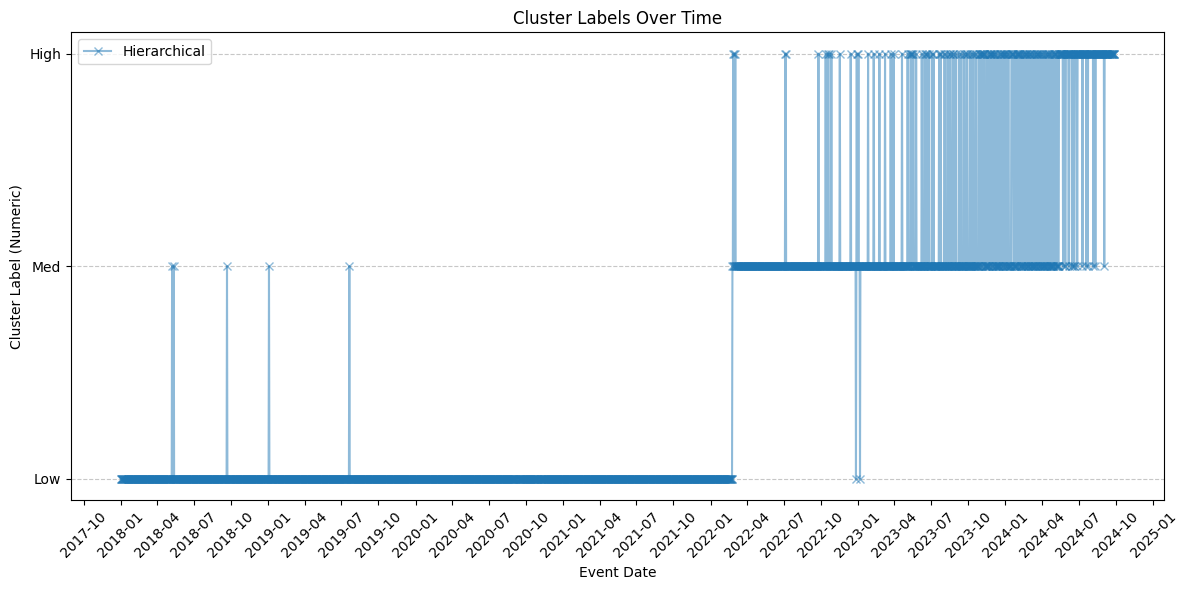

In [81]:
plt.figure(figsize=(12, 6))
# Plot K-Means labels
# plt.plot(vectorized_df['event_date'], vectorized_df['Cluster_KMeans_Label'], label='K-Means', marker='o', alpha=0.5)

# Plot Hierarchical labels
plt.plot(vectorized_df['event_date'], vectorized_df['Cluster_Hierarchical_Label'], label='Hierarchical', marker='x', alpha=0.5)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # Show ticks every 3 months
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m')) 
# Add labels, legend, and grid
plt.title('Cluster Labels Over Time')
plt.xlabel('Event Date')
plt.ylabel('Cluster Label (Numeric)')
plt.yticks([0, 1, 2], ['Low', 'Med', 'High'])  # Map numeric values back to labels
plt.legend()
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

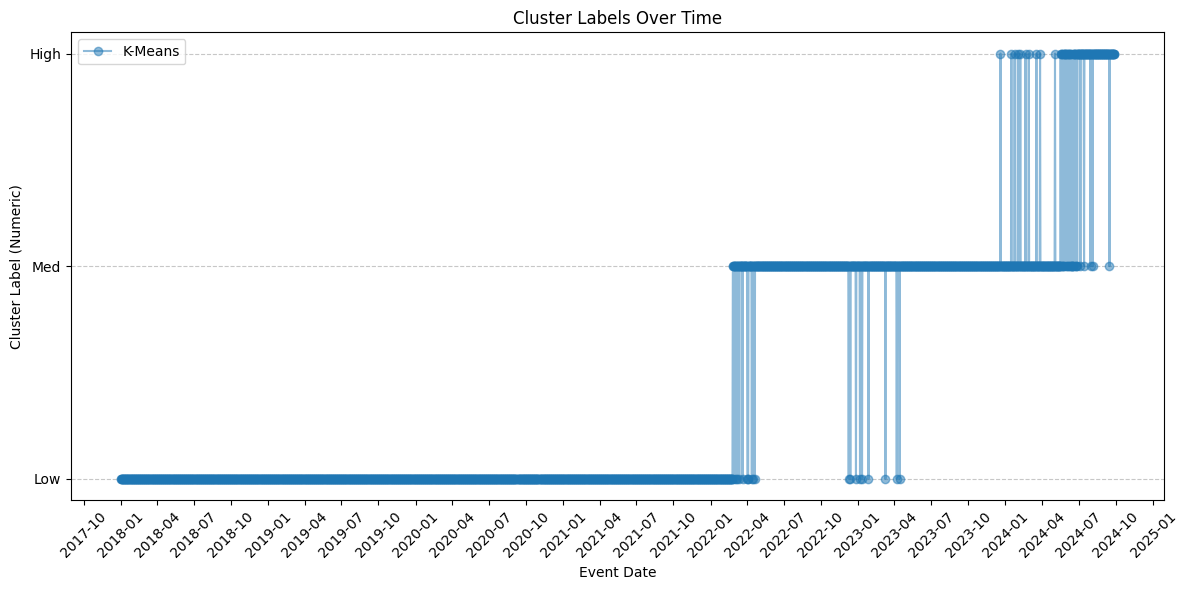

In [80]:
plt.figure(figsize=(12, 6))
# Plot K-Means labels
plt.plot(vectorized_df['event_date'], vectorized_df['Cluster_KMeans_Label'], label='K-Means', marker='o', alpha=0.5)

# Plot Hierarchical labels
# plt.plot(vectorized_df['event_date'], vectorized_df['Cluster_Hierarchical_Label'], label='Hierarchical', marker='x', alpha=0.5)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # Show ticks every 3 months
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m')) 
# Add labels, legend, and grid
plt.title('Cluster Labels Over Time')
plt.xlabel('Event Date')
plt.ylabel('Cluster Label (Numeric)')
plt.yticks([0, 1, 2], ['Low', 'Med', 'High'])  # Map numeric values back to labels
plt.legend()
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

Thoughts: K-Means weights Airstrike+Fatalities meanwhile Hier weights only Fatalities (Airstrike for low and medium is not significant)

Still incline to K-means for me, labeling is less swing too

### GMM

In [85]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=3, random_state=42)
clusters = gmm.fit_predict(vectorized_df_scaled)
vectorized_df['Cluster_GMM'] = clusters

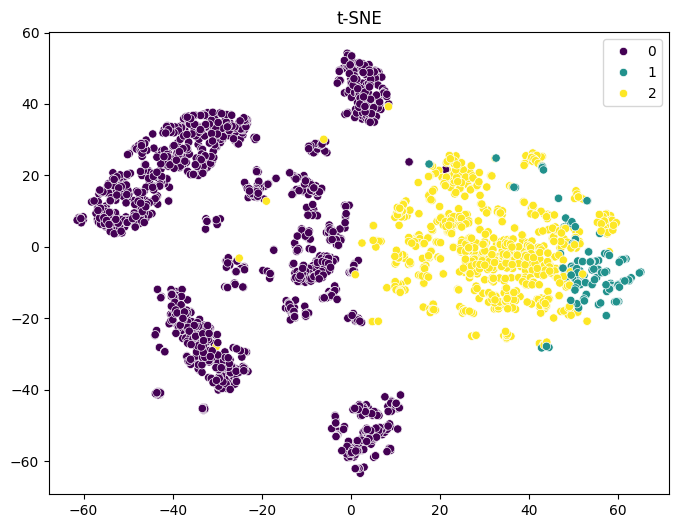

In [86]:
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(vectorized_df_scaled)

# Scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=tsne_results[:, 0], y=tsne_results[:, 1], hue=vectorized_df['Cluster_GMM'], palette='viridis')
plt.title("t-SNE")
plt.legend(loc="best")
plt.show()

/Users/ssutthiboriban/Library/Python/3.9/lib/python/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


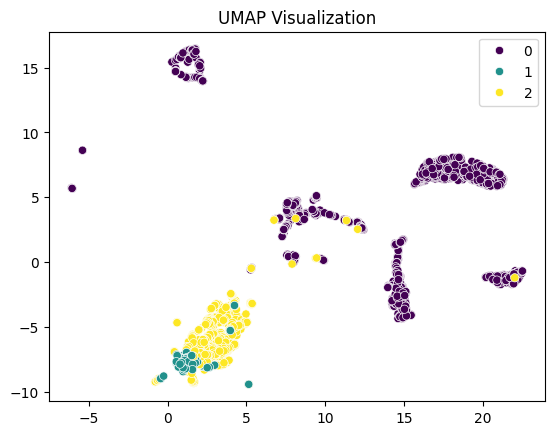

In [87]:
umap_reducer = umap.UMAP(n_components=2, random_state=42)
umap_results = umap_reducer.fit_transform(vectorized_df_scaled)

sns.scatterplot(x=umap_results[:, 0], y=umap_results[:, 1], hue=vectorized_df['Cluster_GMM'], palette='viridis')
plt.title("UMAP Visualization")
plt.legend(loc="best")
plt.show()

In [88]:
vectorized_df.groupby(['Cluster_GMM', 'Cluster']).count()

count_row_clash  count_location_clash  mean_lat_clash  \
Cluster_GMM Cluster                                                          
0           0                   1509                  1509            1509   
1           1                    120                   120             120   
            2                      7                     7               7   
2           0                     22                    22              22   
            2                    799                   799             799   

                     mean_long_clash  sum_fatalities_clash  \
Cluster_GMM Cluster                                          
0           0                   1509                  1509   
1           1                    120                   120   
            2                      7                     7   
2           0                     22                    22   
            2                    799                   799   

                     count_actor1_rus_clash  count_actor1_ukr_clash  \
Cluster_GMM Cluster                                                   
0           0                          1509                    1509   
1           1                           120                     120   
            2                             7                       7   
2           0                            22                      22   
            2                           799                     799   

                     count_actor2_rus_clash  count_actor2_ukr_clash  \
Cluster_GMM Cluster                                                   
0           0                          1509                    1509   
1           1                           120                     120   
            2                             7                       7   
2           0                            22                      22   
            2                           799                     799   

                     is_supported_clash  is_shelling_clash  \
Cluster_GMM Cluster                                          
0           0                      1509               1509   
1           1                       120                120   
            2                         7                  7   
2           0                        22                 22   
            2                       799                799   

                     vehicle_losses_clash  armored_vehicle_losses_clash  \
Cluster_GMM Cluster                                                       
0           0                        1509                          1509   
1           1                         120                           120   
            2                           7                             7   
2           0                          22                            22   
            2                         799                           799   

                     car_losses_clash  boat_losses_clash  drone_losses_clash  \
Cluster_GMM Cluster                                                            
0           0                    1509               1509                1509   
1           1                     120                120                 120   
            2                       7                  7                   7   
2           0                      22                 22                  22   
            2                     799                799                 799   

                     cannon_losses_clash  uav_losses_clash  \
Cluster_GMM Cluster                                          
0           0                       1509              1509   
1           1                        120               120   
            2                          7                 7   
2           0                         22                22   
            2                        799               799   

                     mortar_losses_clash  air_forces_supported_clash  \
Cluster_GMM Cl

almost similar to K-Means

In [90]:
gmm_cluster_summary = vectorized_df.drop(columns=['event_date', 'Cluster_DBSCAN', 'Cluster', 'Cluster_KMeans_Label','Cluster_Hierarchical_Label','Cluster_Hierarchical']).groupby('Cluster_GMM').mean()
gmm_cluster_summary

,count_row_clash,count_location_clash,mean_lat_clash,mean_long_clash,sum_fatalities_clash,count_actor1_rus_clash,count_actor1_ukr_clash,count_actor2_rus_clash,count_actor2_ukr_clash,is_supported_clash,is_shelling_clash,vehicle_losses_clash,armored_vehicle_losses_clash,car_losses_clash,boat_losses_clash,drone_losses_clash,cannon_losses_clash,uav_losses_clash,mortar_losses_clash,air_forces_supported_clash,artillery_supported_clash,aviation_supported_clash,air_units_supported_clash,count_row_shelling,count_location_shelling,mean_lat_shelling,mean_long_shelling,sum_fatalities_shelling,count_actor1_rus_shelling,count_actor1_ukr_shelling,count_actor2_rus_shelling,count_actor2_ukr_shelling,shelling_flag_shelling,artillery_flag_shelling,missile_flag_shelling,mortar_flag_shelling,missile_type_shelling,anti-tank_shelling,anti-aircraft_shelling,anti-ship_shelling,anti-air_shelling,anti-radar_shelling,grad_shelling,himars_shelling,s-300_shelling,uragan_shelling,iskander_shelling,c-300_shelling,mlrs_shelling,ballistic_shelling,tochka_shelling,smerch_shelling,kalibr_shelling,high-precision_shelling,storm-shadow_shelling,count_row_disrupt,count_location_disrupt,mean_lat_disrupt,mean_long_disrupt,sum_fatalities_disrupt,count_actor1_rus_disrupt,count_actor1_ukr_disrupt,count_actor2_rus_disrupt,count_actor2_ukr_disrupt,n_drone_launched_disrupt,flag_drone_launched_disrupt,n_drone_intercepted_disrupt,flag_drone_intercepted_disrupt,n_kamikaze-drone_launched_disrupt,flag_kamikaze-drone_launched_disrupt,n_kamikaze-drone_intercepted_disrupt,flag_kamikaze-drone_intercepted_disrupt,n_air-bomb_launched_disrupt,flag_air-bomb_launched_disrupt,n_air-bomb_intercepted_disrupt,flag_air-bomb_intercepted_disrupt,n_missile_launched_disrupt,flag_missile_launched_disrupt,n_missile_intercepted_disrupt,flag_missile_intercepted_disrupt,n_uxo_launched_disrupt,flag_uxo_launched_disrupt,n_uxo_intercepted_disrupt,flag_uxo_intercepted_disrupt,n_artillery-shell_launched_disrupt,flag_artillery-shell_launched_disrupt,n_artillery-shell_intercepted_disrupt,flag_artillery-shell_intercepted_disrupt,n_aviation-bomb_launched_disrupt,flag_aviation-bomb_launched_disrupt,n_aviation-bomb_intercepted_disrupt,flag_aviation-bomb_intercepted_disrupt,n_ballistic_launched_disrupt,flag_ballistic_launched_disrupt,n_ballistic_intercepted_disrupt,flag_ballistic_intercepted_disrupt,n_bomb_launched_disrupt,flag_bomb_launched_disrupt,n_bomb_intercepted_disrupt,flag_bomb_intercepted_disrupt,n_explosive_launched_disrupt,flag_explosive_launched_disrupt,n_explosive_intercepted_disrupt,flag_explosive_intercepted_disrupt,n_glider-bomb_launched_disrupt,flag_glider-bomb_launched_disrupt,n_glider-bomb_intercepted_disrupt,flag_glider-bomb_intercepted_disrupt,count_row_airstrike,count_location_airstrike,mean_lat_airstrike,mean_long_airstrike,sum_fatalities_airstrike,count_actor1_rus_airstrike,count_actor1_ukr_airstrike,count_actor2_rus_airstrike,count_actor2_ukr_airstrike,flag_drone_airstrike,flag_drone-strike_airstrike,flag_mortar_airstrike,flag_air-strike_airstrike,flag_kamikaze-drone_airstrike,flag_artillery_airstrike,n_drone-strike_airstrike,n_artillery_airstrike,count_row_regain,count_location_regain,mean_lat_regain,mean_long_regain,sum_fatalities_regain,count_actor1_rus_regain,count_actor1_ukr_regain,count_actor2_rus_regain,count_actor2_ukr_regain,sum_fatalities
Cluster_GMM,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,14.677932,14.667329,47.457545,37.658395,0.836315,0.086812,7.795891,0.076209,6.855533,0.000000,0.017230,0.013254,0.000000,0.020543,0.000000,0.009940,0.788602,0.000000,48.090126,0.000000,0.000000,0.000000,0.000000,14.822399,14.796554,47.759727,37.801430,0.180252,0.029821,8.327369,0.001988,3.003313,0.098078,0.229291,0.121272,0.756130,0.121272,0.117296,0.000000,0.000663,0.000000,0.000000,0.001325,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000663,0.000000,0.000000,0.000000,0.00000,0.000000,

In [91]:
# Calculate the range (max - min) of each feature across clusters
gmm_feature_variances = gmm_cluster_summary.max() - gmm_cluster_summary.min()

# Sort features by variance
gmm_top_features = gmm_feature_variances.sort_values(ascending=False).head(10)
print("Top Differentiating Features:\n", gmm_top_features)
gmm_selected_features = gmm_top_features.index

Top Differentiating Features:
 n_artillery_airstrike          318.590551
sum_fatalities                 240.427378
sum_fatalities_clash           203.880220
n_drone-strike_airstrike       169.433071
n_drone_intercepted_disrupt     85.670304
count_row_airstrike             78.191158
count_location_airstrike        77.238402
count_row_shelling              75.010731
count_location_shelling         73.426345
count_actor1_rus_shelling       71.642530
dtype: float64


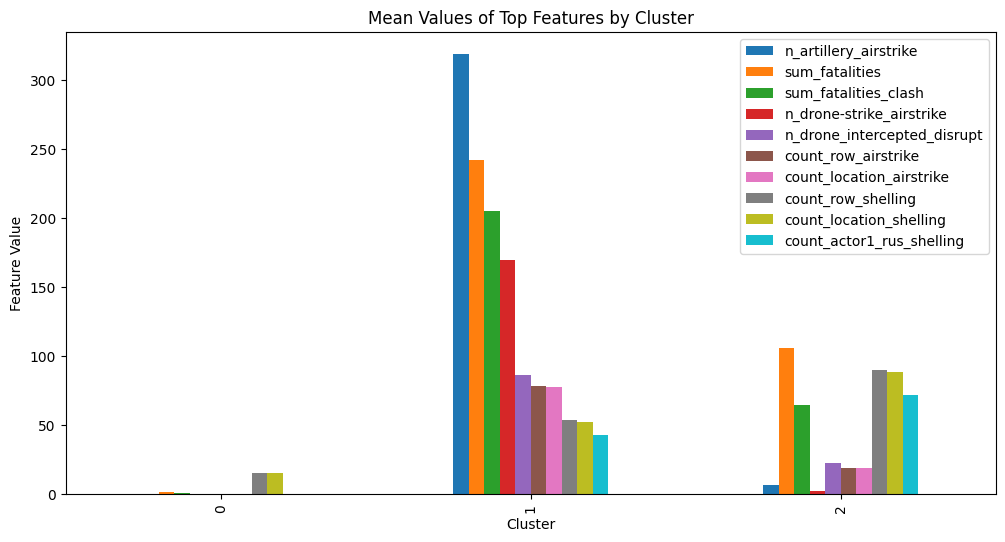

In [92]:
# Plot mean values for each feature across clusters
gmm_cluster_summary[gmm_selected_features].plot(kind='bar', figsize=(12, 6))
plt.title("Mean Values of Top Features by Cluster")
plt.xlabel("Cluster")
plt.ylabel("Feature Value")
plt.legend(loc="upper right")
plt.show()

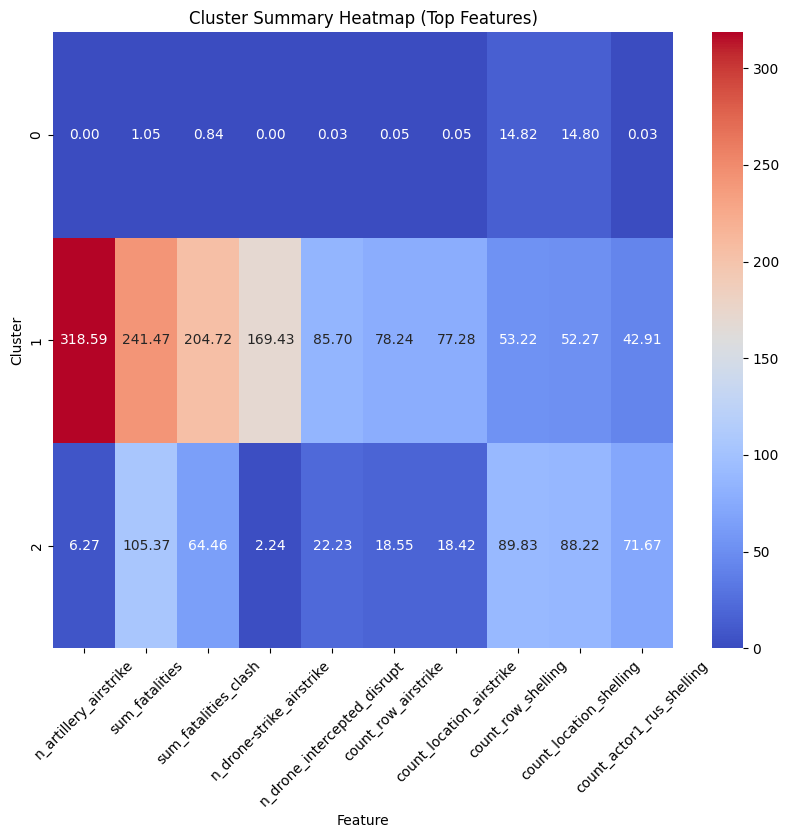

In [93]:
# Plot a heatmap for top features
plt.figure(figsize=(10, 8))
sns.heatmap(gmm_cluster_summary[gmm_selected_features], annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Cluster Summary Heatmap (Top Features)")
plt.xlabel("Feature")
plt.xticks(rotation=45)
plt.ylabel("Cluster")
plt.show()

In [94]:
gmm_labels = {0: 'low', 1: 'high', 2: 'med'}

# Apply the mappings to create new labeled columns
vectorized_df['Cluster_GMM_Label'] = vectorized_df['Cluster_GMM'].map(gmm_labels)

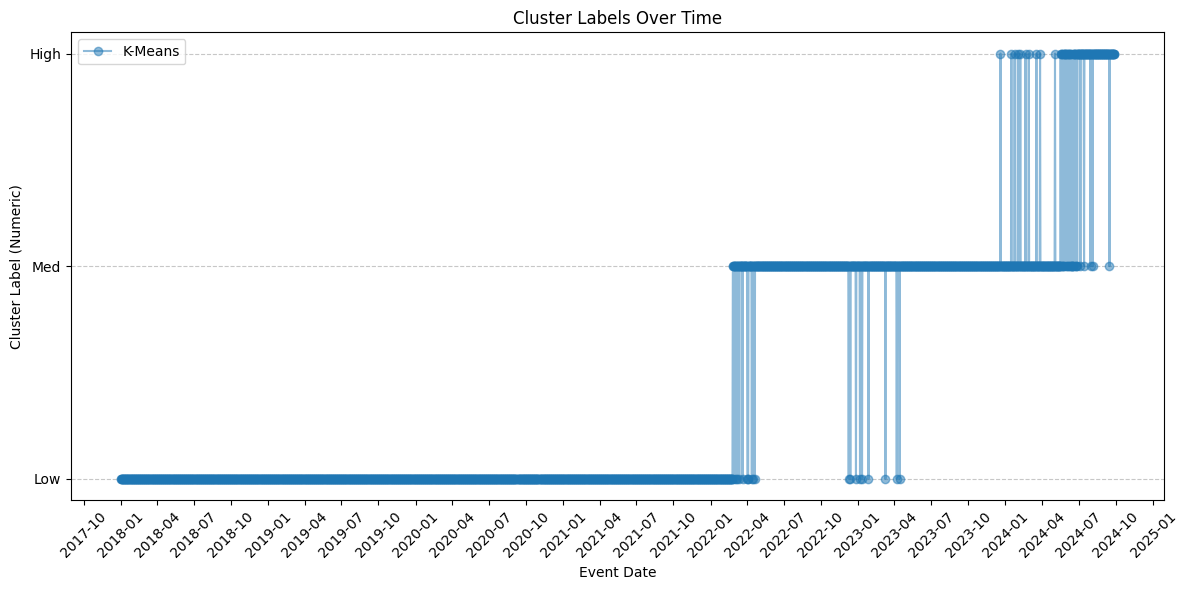

In [97]:
plt.figure(figsize=(12, 6))
# Plot K-Means labels
plt.plot(vectorized_df['event_date'], vectorized_df['Cluster_KMeans_Label'], label='K-Means', marker='o', alpha=0.5)

# Plot Hierarchical labels
# plt.plot(vectorized_df['event_date'], vectorized_df['Cluster_GMM_Label'], label='GMM', marker='x', alpha=0.5)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # Show ticks every 3 months
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m')) 
# Add labels, legend, and grid
plt.title('Cluster Labels Over Time')
plt.xlabel('Event Date')
plt.ylabel('Cluster Label (Numeric)')
plt.yticks([0, 1, 2], ['Low', 'Med', 'High'])  # Map numeric values back to labels
plt.legend()
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

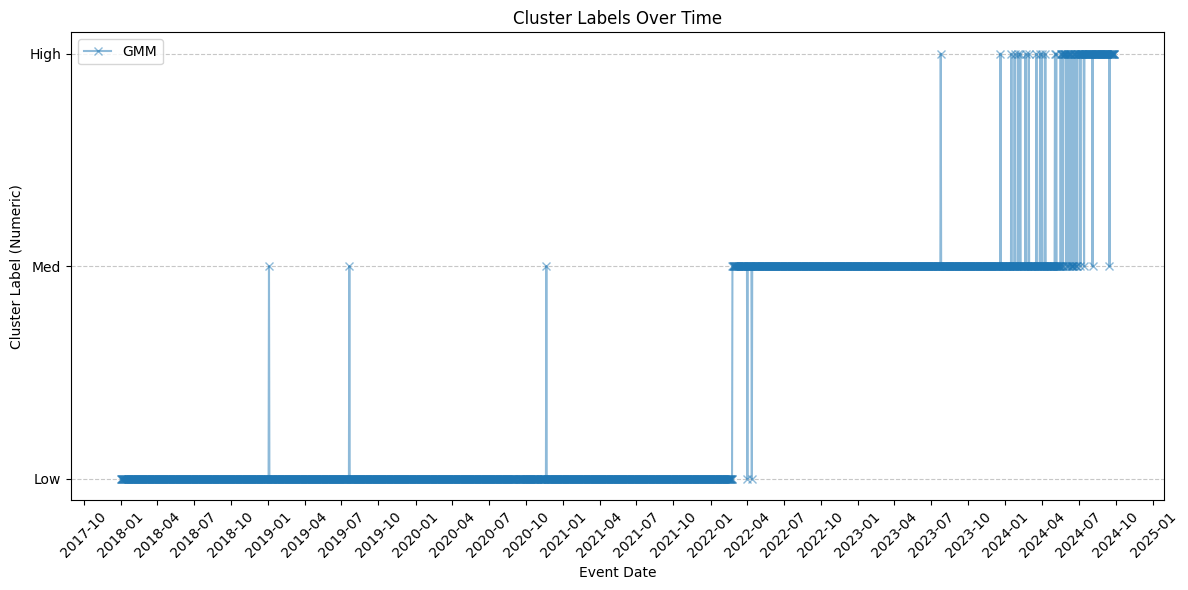

In [96]:
plt.figure(figsize=(12, 6))
# Plot K-Means labels
# plt.plot(vectorized_df['event_date'], vectorized_df['Cluster_KMeans_Label'], label='K-Means', marker='o', alpha=0.5)

# Plot Hierarchical labels
plt.plot(vectorized_df['event_date'], vectorized_df['Cluster_GMM_Label'], label='GMM', marker='x', alpha=0.5)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # Show ticks every 3 months
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m')) 
# Add labels, legend, and grid
plt.title('Cluster Labels Over Time')
plt.xlabel('Event Date')
plt.ylabel('Cluster Label (Numeric)')
plt.yticks([0, 1, 2], ['Low', 'Med', 'High'])  # Map numeric values back to labels
plt.legend()
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

Thoughts: Can we call these as hallucinations (medium labeling before the period of war)? / Rely solely on airstrike

Are O labels during the start of the war reliable for K-means?

	GMM:
	•	Works well for data with gradual changes and overlapping clusters.
	•	Likely the most suitable if the war’s intensity fluctuates between levels without sharp distinctions.
	K-Means:
	•	Provides a clear and interpretable timeline.
	•	Suitable if the goal is to divide the conflict into distinct phases of intensity (e.g., low, med, high).
	Hierarchical Clustering:
	•	Useful for identifying the overall structure or relationships but may be less practical for time-series labeling.

TLDR: K-means for sharp transition, GMM for gradual changes

Compare to actual big events?